In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datasketch import MinHash, MinHashLSH

warnings.filterwarnings("ignore")

### Исходя из предоставленных данных мы видим что у нас существует 3 источника данных (properties_1 и properties_2 были разбиты скорее из-за оптимизационных процессов), следовательно нужно на этапе предобработки данных создать функционал который в последствии будет выделен в ноды микросервиса.

In [2]:
# Создадим датафреймы на основе предоставленных данных
events = pd.read_csv("./data/events.csv")

category_tree = pd.read_csv("./data/category_tree.csv")

properties_1 = pd.read_csv("./data/item_properties_part1.csv")
properties_2 = pd.read_csv("./data/item_properties_part2.csv")
item_properties = pd.concat([properties_1, properties_2])

# Приведем к временному формату данные из timestapm
events["timestamp"] = pd.to_datetime(events["timestamp"], unit="ms")
item_properties["timestamp"] = pd.to_datetime(item_properties["timestamp"], unit="ms")

In [3]:
# Отобразим структуру таблиц
print("Структура данных")
display(events.head(), category_tree.head(), item_properties.head())

Структура данных


,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


,timestamp,itemid,property,value
0,2015-06-28 03:00:00,460429,categoryid,1338
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481,790,n15360.000
4,2015-05-17 03:00:00,156781,917,828513


Отобразим типы данных таблиц

In [4]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 105.1+ MB


In [5]:
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [6]:
item_properties.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   itemid     int64         
 2   property   object        
 3   value      object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 773.5+ MB


---
> events — датасет с событиями. Колонки:

• timestamp — время события

• visitorid — идентификатор пользователя

• event — тип события

• itemid — идентификатор объекта

• transactionid — идентификатор транзакции, если она проходила


> category_tree   — файл с деревом категорий (можно восстановить дерево).

• category_id — идентификатор категорий

• parent_id — идентификатор родительской категории



> item_properties - файл с свойствами товаров.

• timestamp — момент записи значения свойства

• item_id — идентификатор объекта

• property — свойство, кажется, они все, кроме категории, захешированы

• value — значение свойства


----

## Поработаем с фреймом events


In [7]:
# Глянем есть ли пропущенные значения
events["visitorid"].isna().value_counts()

visitorid
False    2756101
Name: count, dtype: int64

> Пропусков нет


In [8]:
# Посмотрим на количество уникальных покупателей
events["visitorid"].nunique()

1407580

> Можно предположить что на каждого уникального покупателя в среднем приходится ~2 покупки

In [9]:
# Вычленим idшники покупателей и количество совершенных ими ПОКУПОК (как интересующего вида транзаций)
visitors_transaction = pd.DataFrame(
    events["visitorid"][events["event"] == "transaction"].value_counts()
).reset_index()

# Посмотрим на статистики
visitors_transaction.describe()

,visitorid,count
count,1.171900e+04,11719.000000
mean,7.099856e+05,1.916290
std,4.058287e+05,8.850529
min,1.720000e+02,1.000000
25%,3.591195e+05,1.000000
50%,7.183140e+05,1.000000
75%,1.062739e+06,1.000000
max,1.407398e+06,559.000000


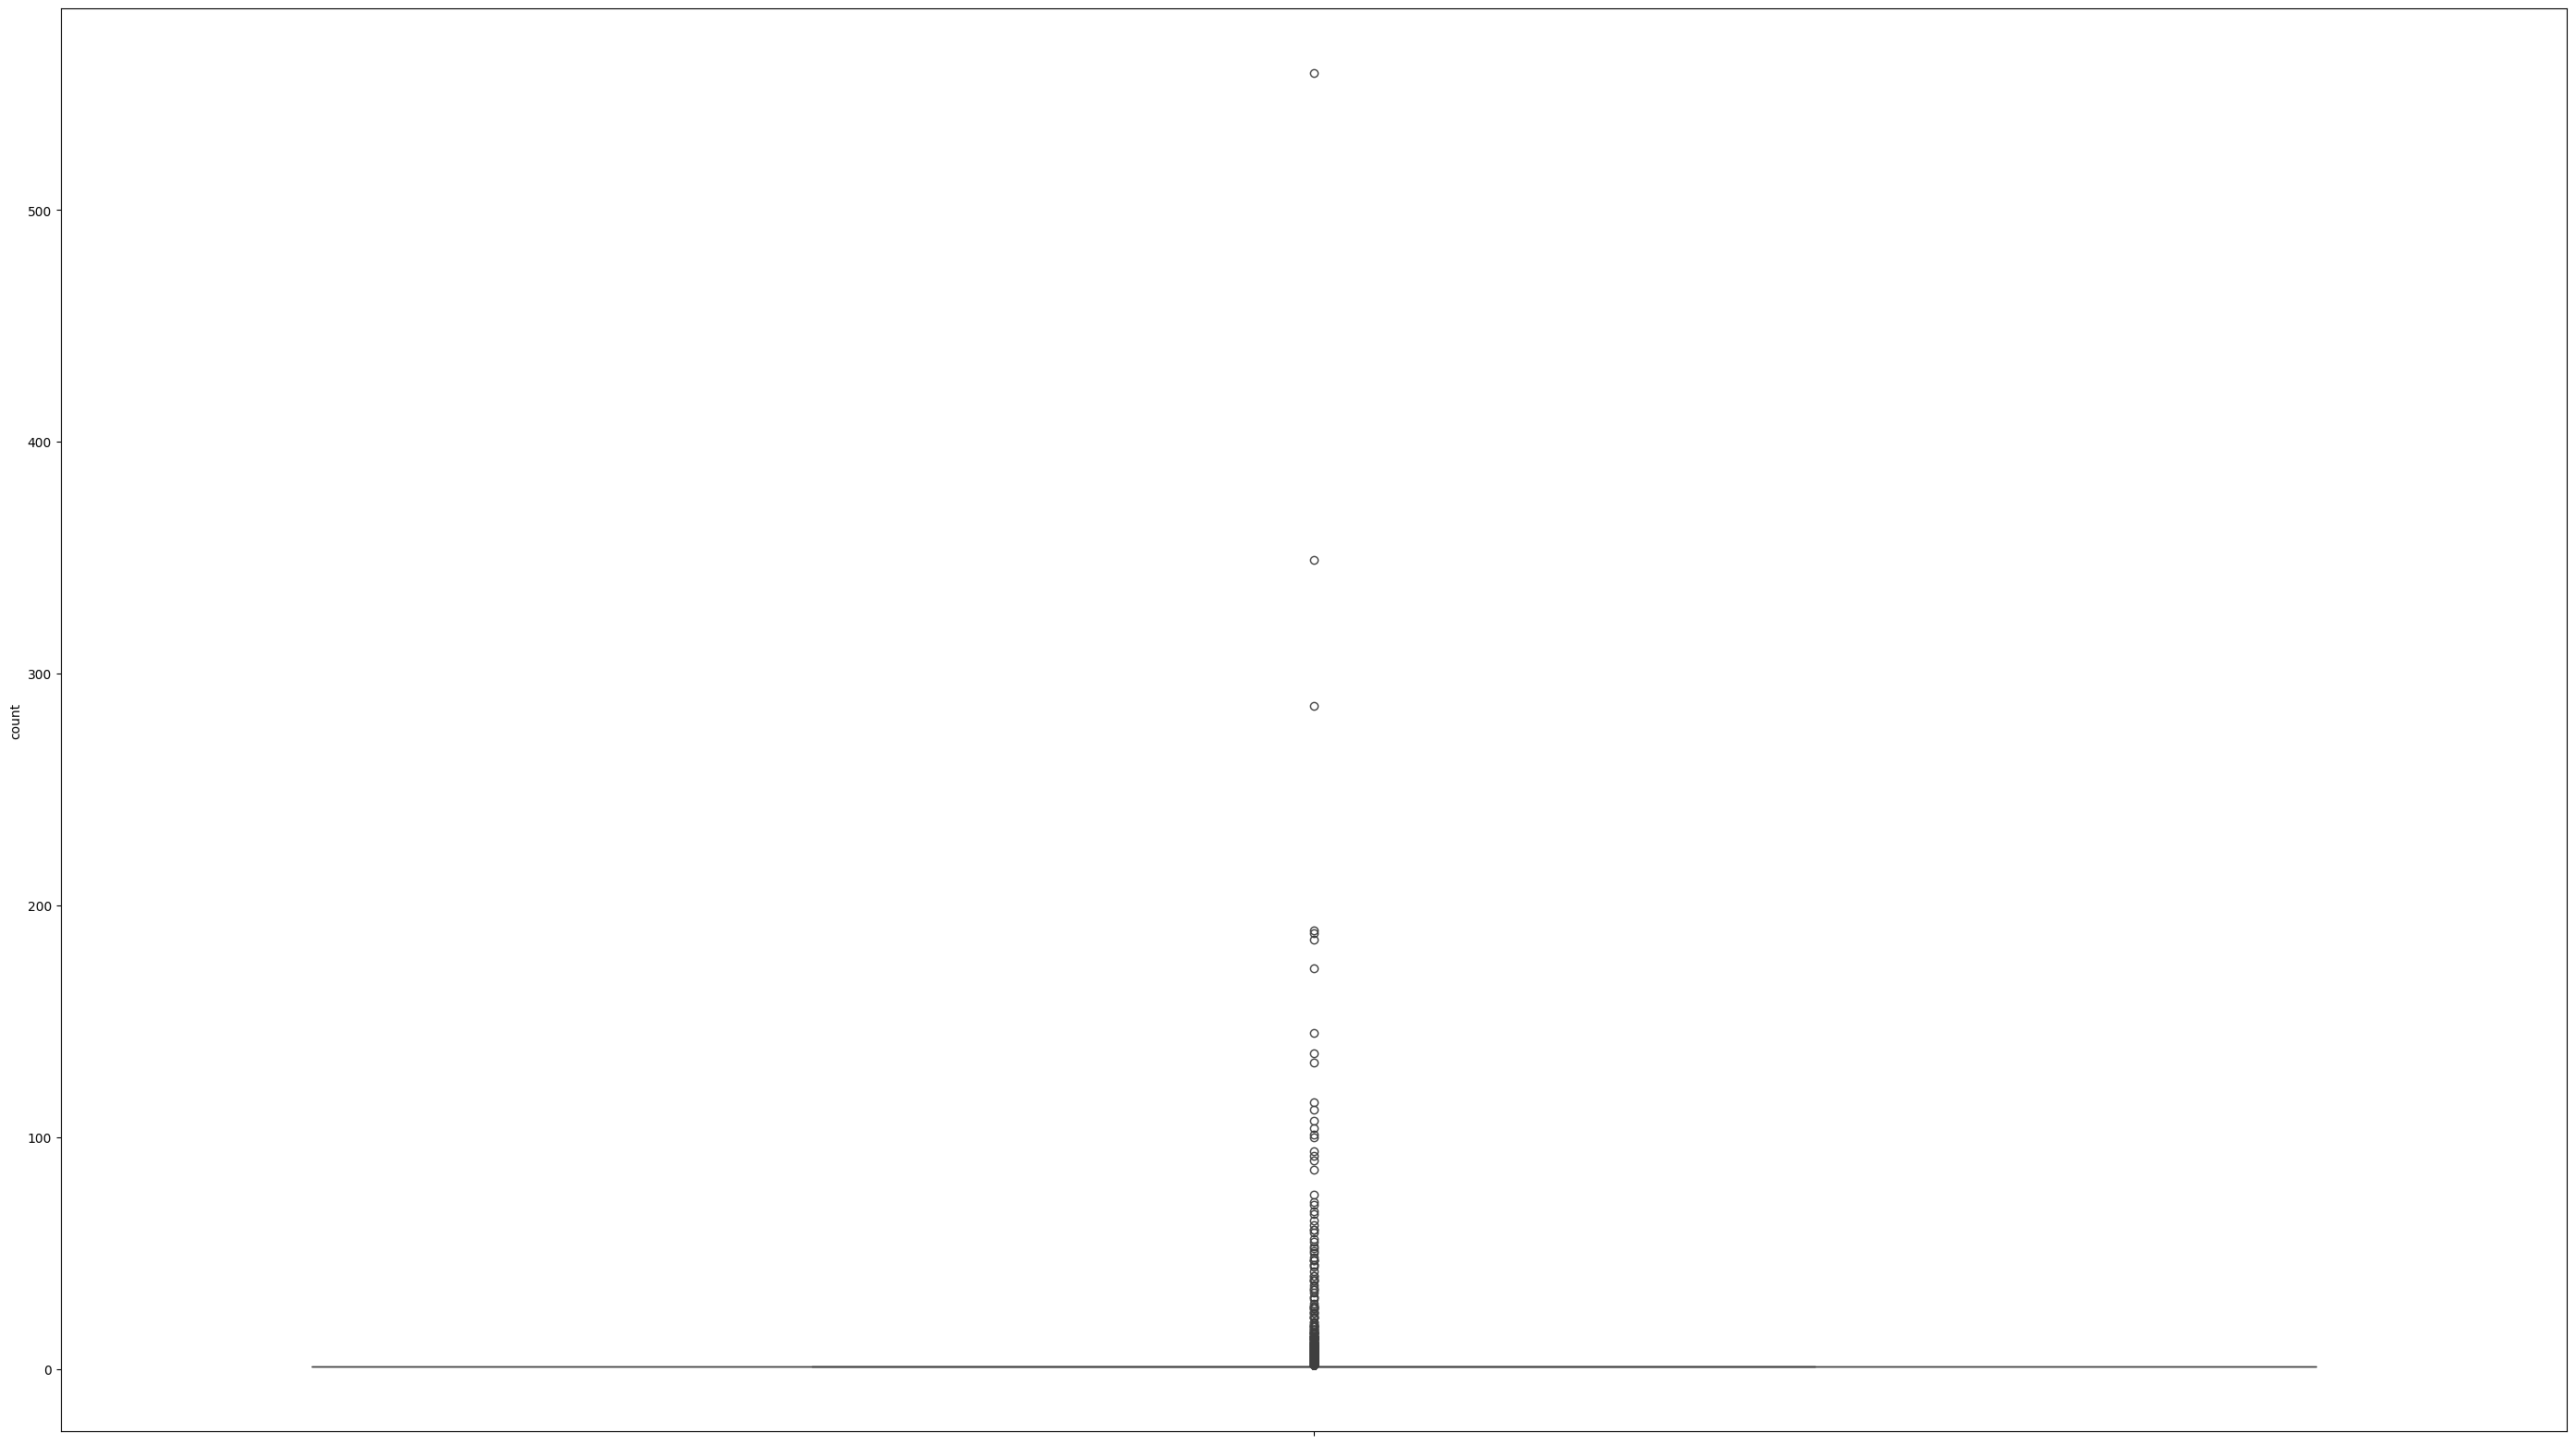

In [10]:
# Глянем на боксплот
fig, axes = plt.subplots(1, 1, figsize=(35, 20))
sns.boxplot(visitors_transaction["count"], ax=axes)

plt.show()

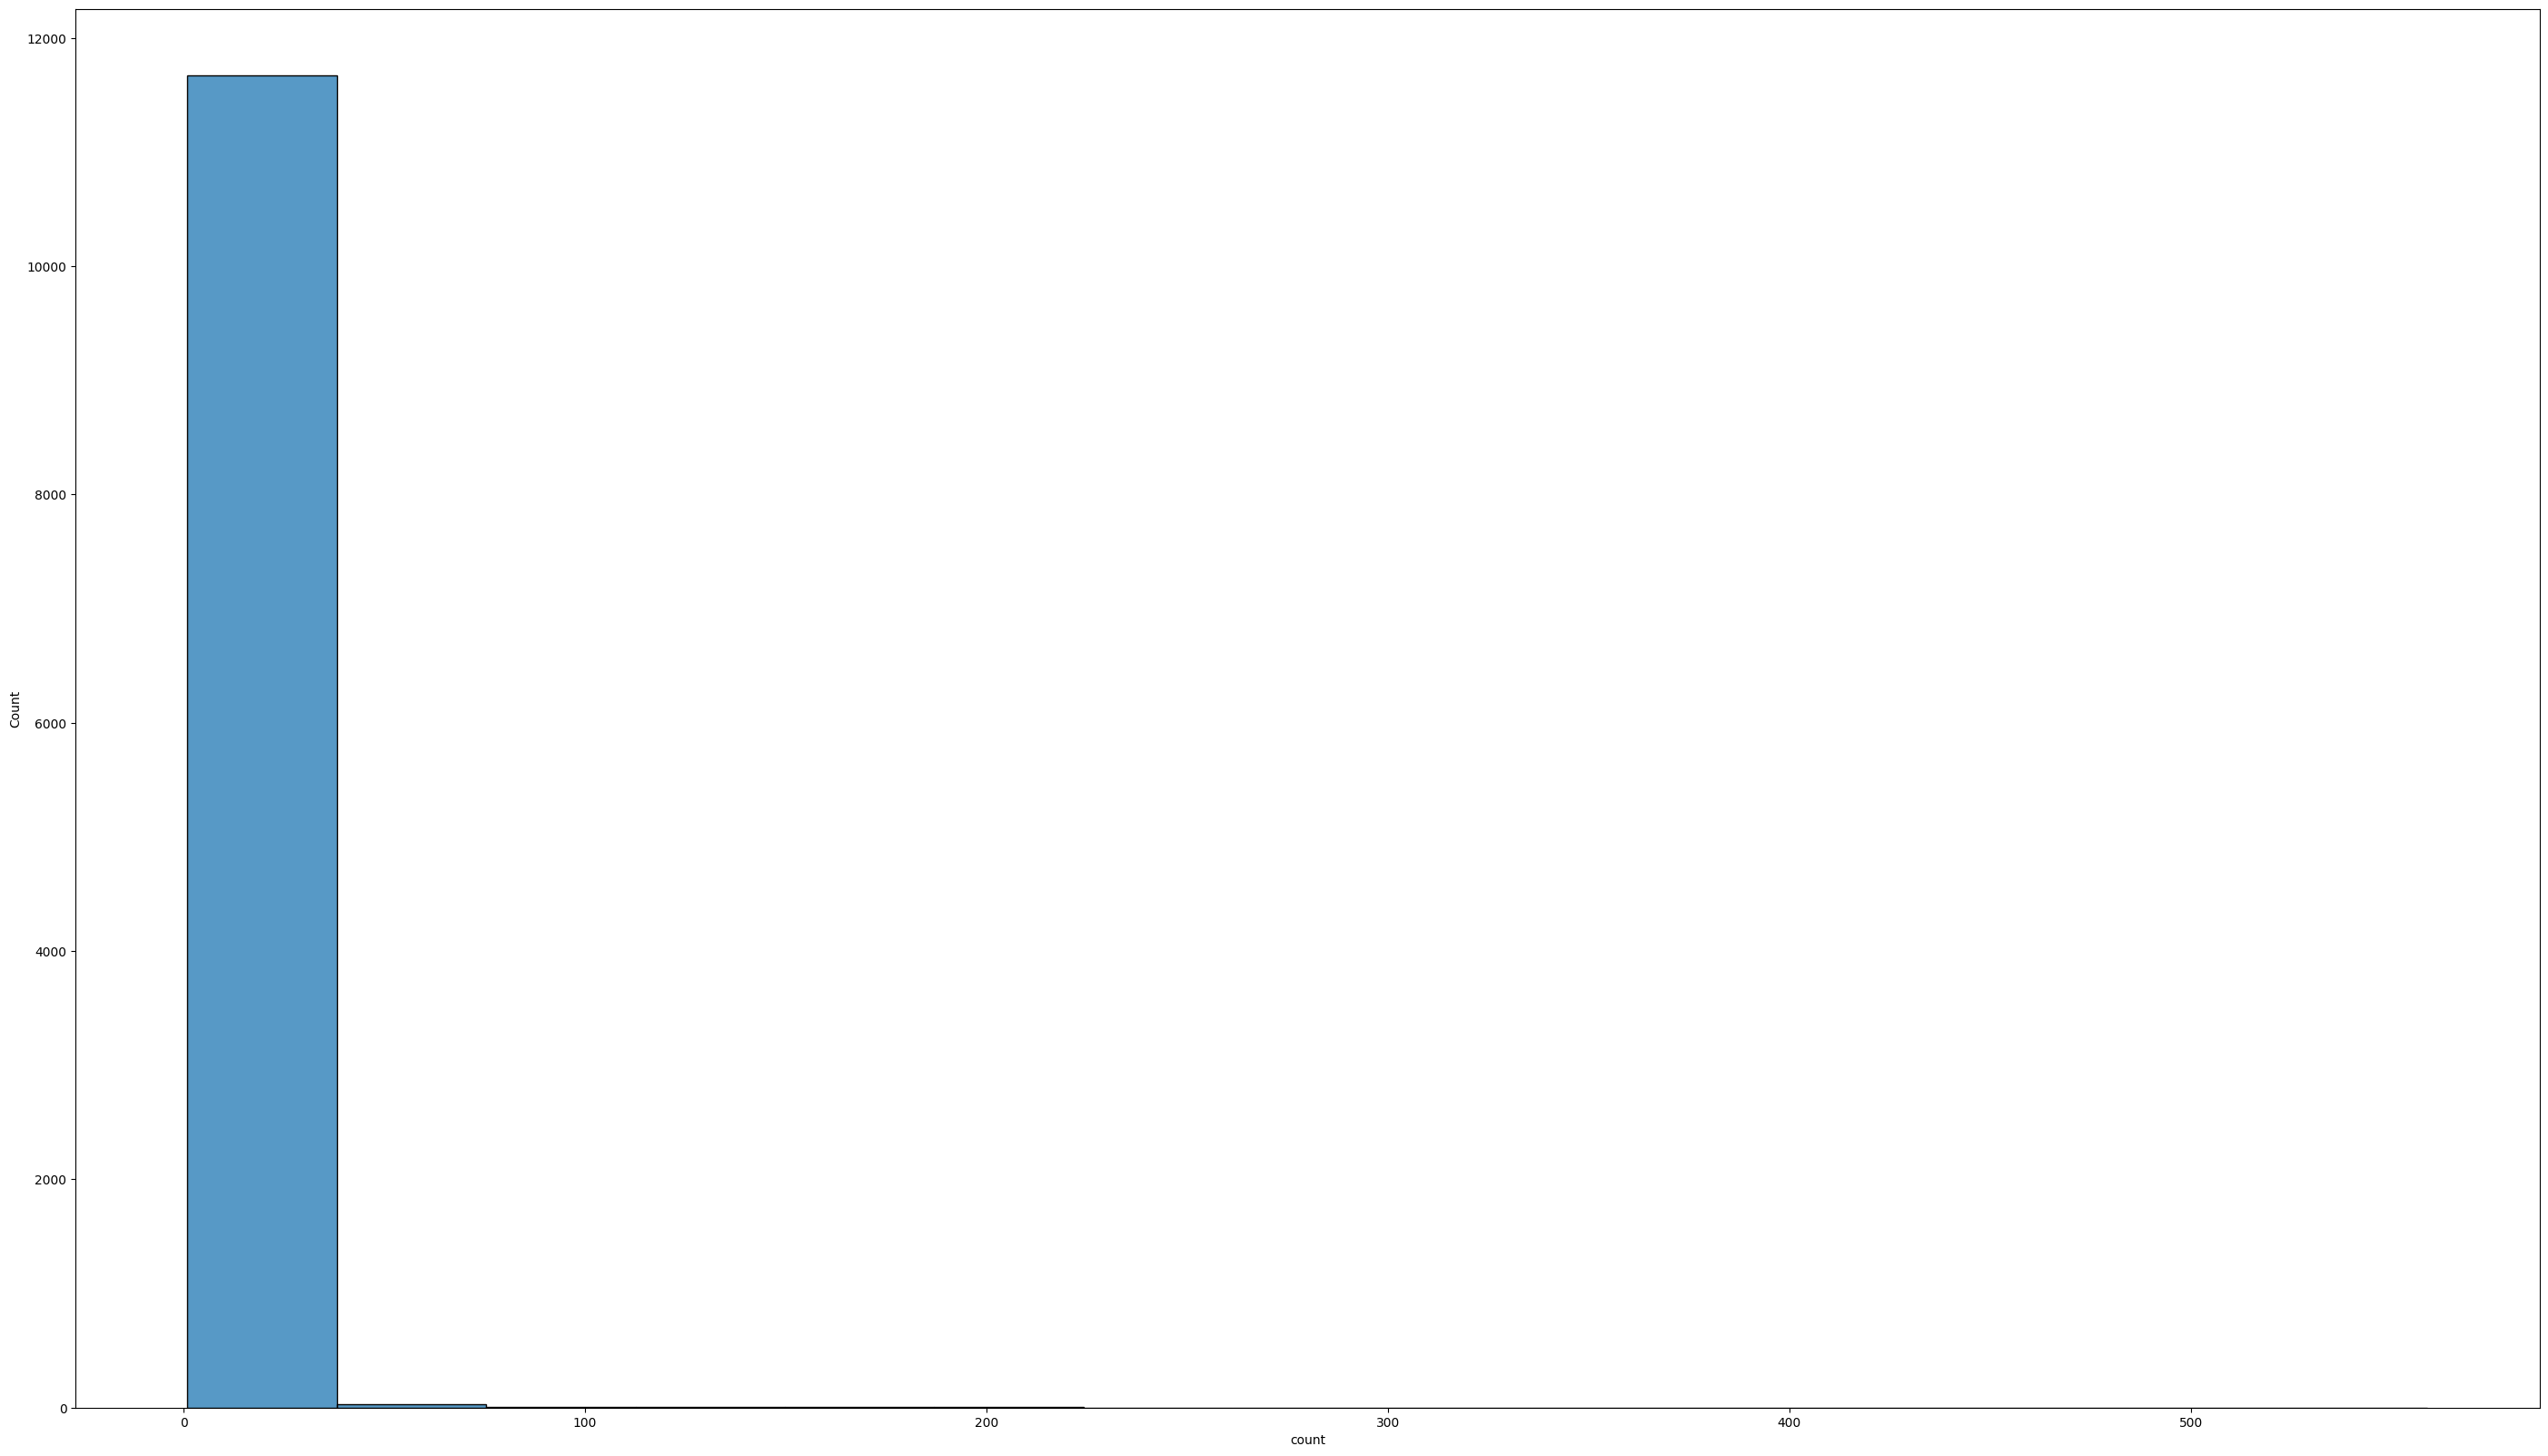

In [11]:
# Посмотрим гистрограмму распределения
fig, axes = plt.subplots(1, 1, figsize=(35, 20))
sns.histplot(visitors_transaction["count"], ax=axes)

plt.show()

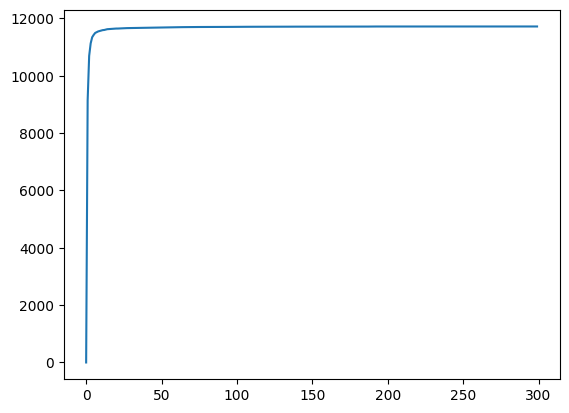

In [12]:
# Визуализируем диапазон в котором находится основная часть покупок по id
product_list = []
for i in range(300):
    product_list.append(
        visitors_transaction[visitors_transaction["count"] <= i].shape[0]
    )

# Посмотрим переломный момент по покупкам
sns.lineplot(product_list)
plt.show()

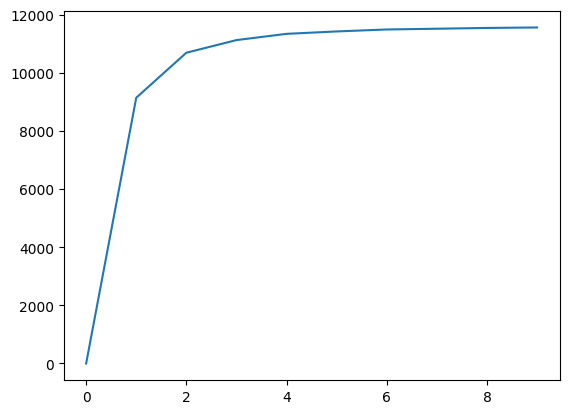

In [13]:
# Уменьшим скоуп для визуализации
product_list = []
for i in range(10):
    product_list.append(
        visitors_transaction[visitors_transaction["count"] <= i].shape[0]
    )

# Посмотрим переломный момент по покупкам
sns.lineplot(product_list)
plt.show()

> Можно видеть, что основная часть покупателей совершает покупки до ~4-6 штук, при этом описание статистик говорит о среднем равном 2 и стандартном отклонении равном 9, поскольку отрицательные значения не допускаются, это может указывать на то, что данное распределение имеет смещение вправо. Также можно предположить, что большинство значений сконцентрированы справа от среднего значения, но при этом имеют большой разброс распределение равномерно, но наличествуют аномалии в данных, которые могут свидетельствовать о наличии оптовых покупателей, для которых разрабатываемая системе рекомендаций не имеет смысла в виду B2B формата закупок этих агентов, но это нужно проверить.

---
### Посмотрим itemid таблицы events: распределение, уникальные значения, пропуски

In [14]:
# Глянем есть ли пропущенные значения
events["itemid"].isna().value_counts()

itemid
False    2756101
Name: count, dtype: int64

> Пропусков нет

In [15]:
# Посмотрим на количество уникальных товаров
events["itemid"].nunique()

235061

> Что предсказуемо количество уникальных товаров значительно уступает количеству уникальных пользователей

In [16]:
# Вычленим idшники товаров которые были куплены
item_transaction = pd.DataFrame(
    events["itemid"][events["event"] == "transaction"].value_counts()
).reset_index()

item_transaction.head()

,itemid,count
0,461686,133
1,119736,97
2,213834,92
3,312728,46
4,7943,46


In [17]:
# Посмотрим на статистики
item_transaction.describe()

,itemid,count
count,12025.000000,12025.000000
mean,233918.108857,1.867526
std,133811.807113,2.710560
min,15.000000,1.000000
25%,117674.000000,1.000000
50%,234299.000000,1.000000
75%,349516.000000,2.000000
max,466861.000000,133.000000


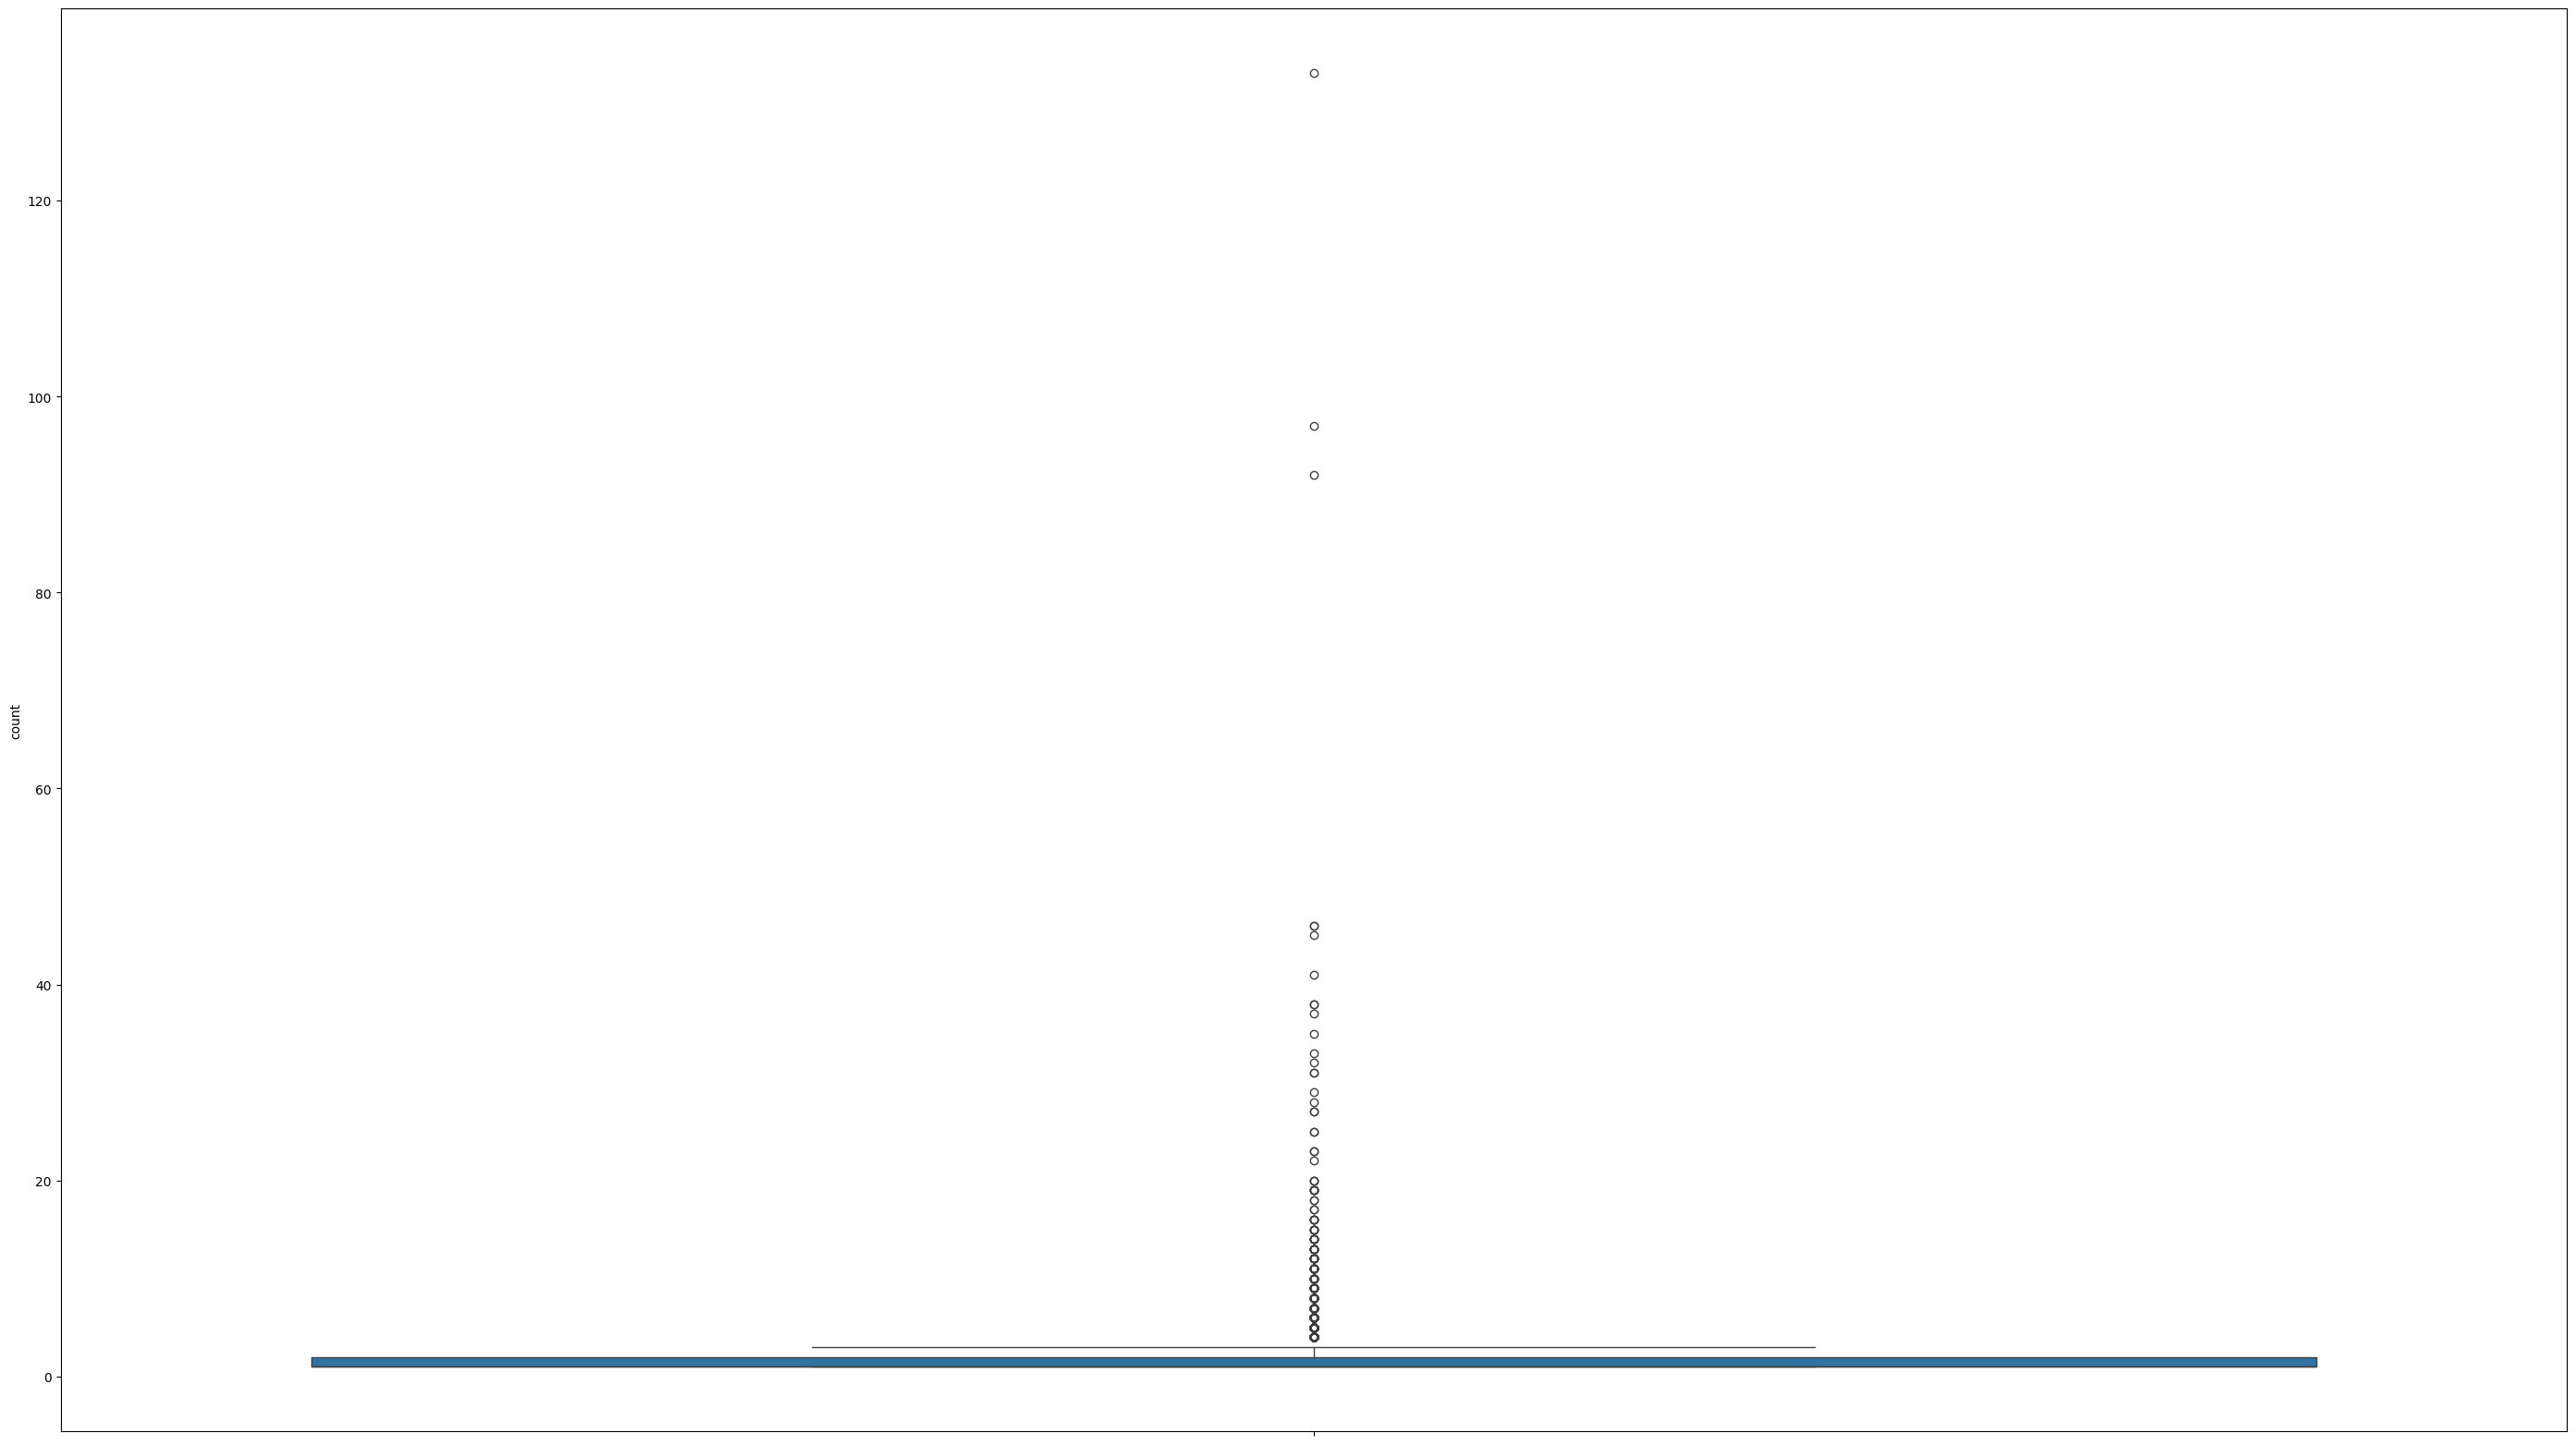

In [18]:
# Глянем на боксплот
fig, axes = plt.subplots(1, 1, figsize=(35, 20))
sns.boxplot(item_transaction["count"], ax=axes)

plt.show()

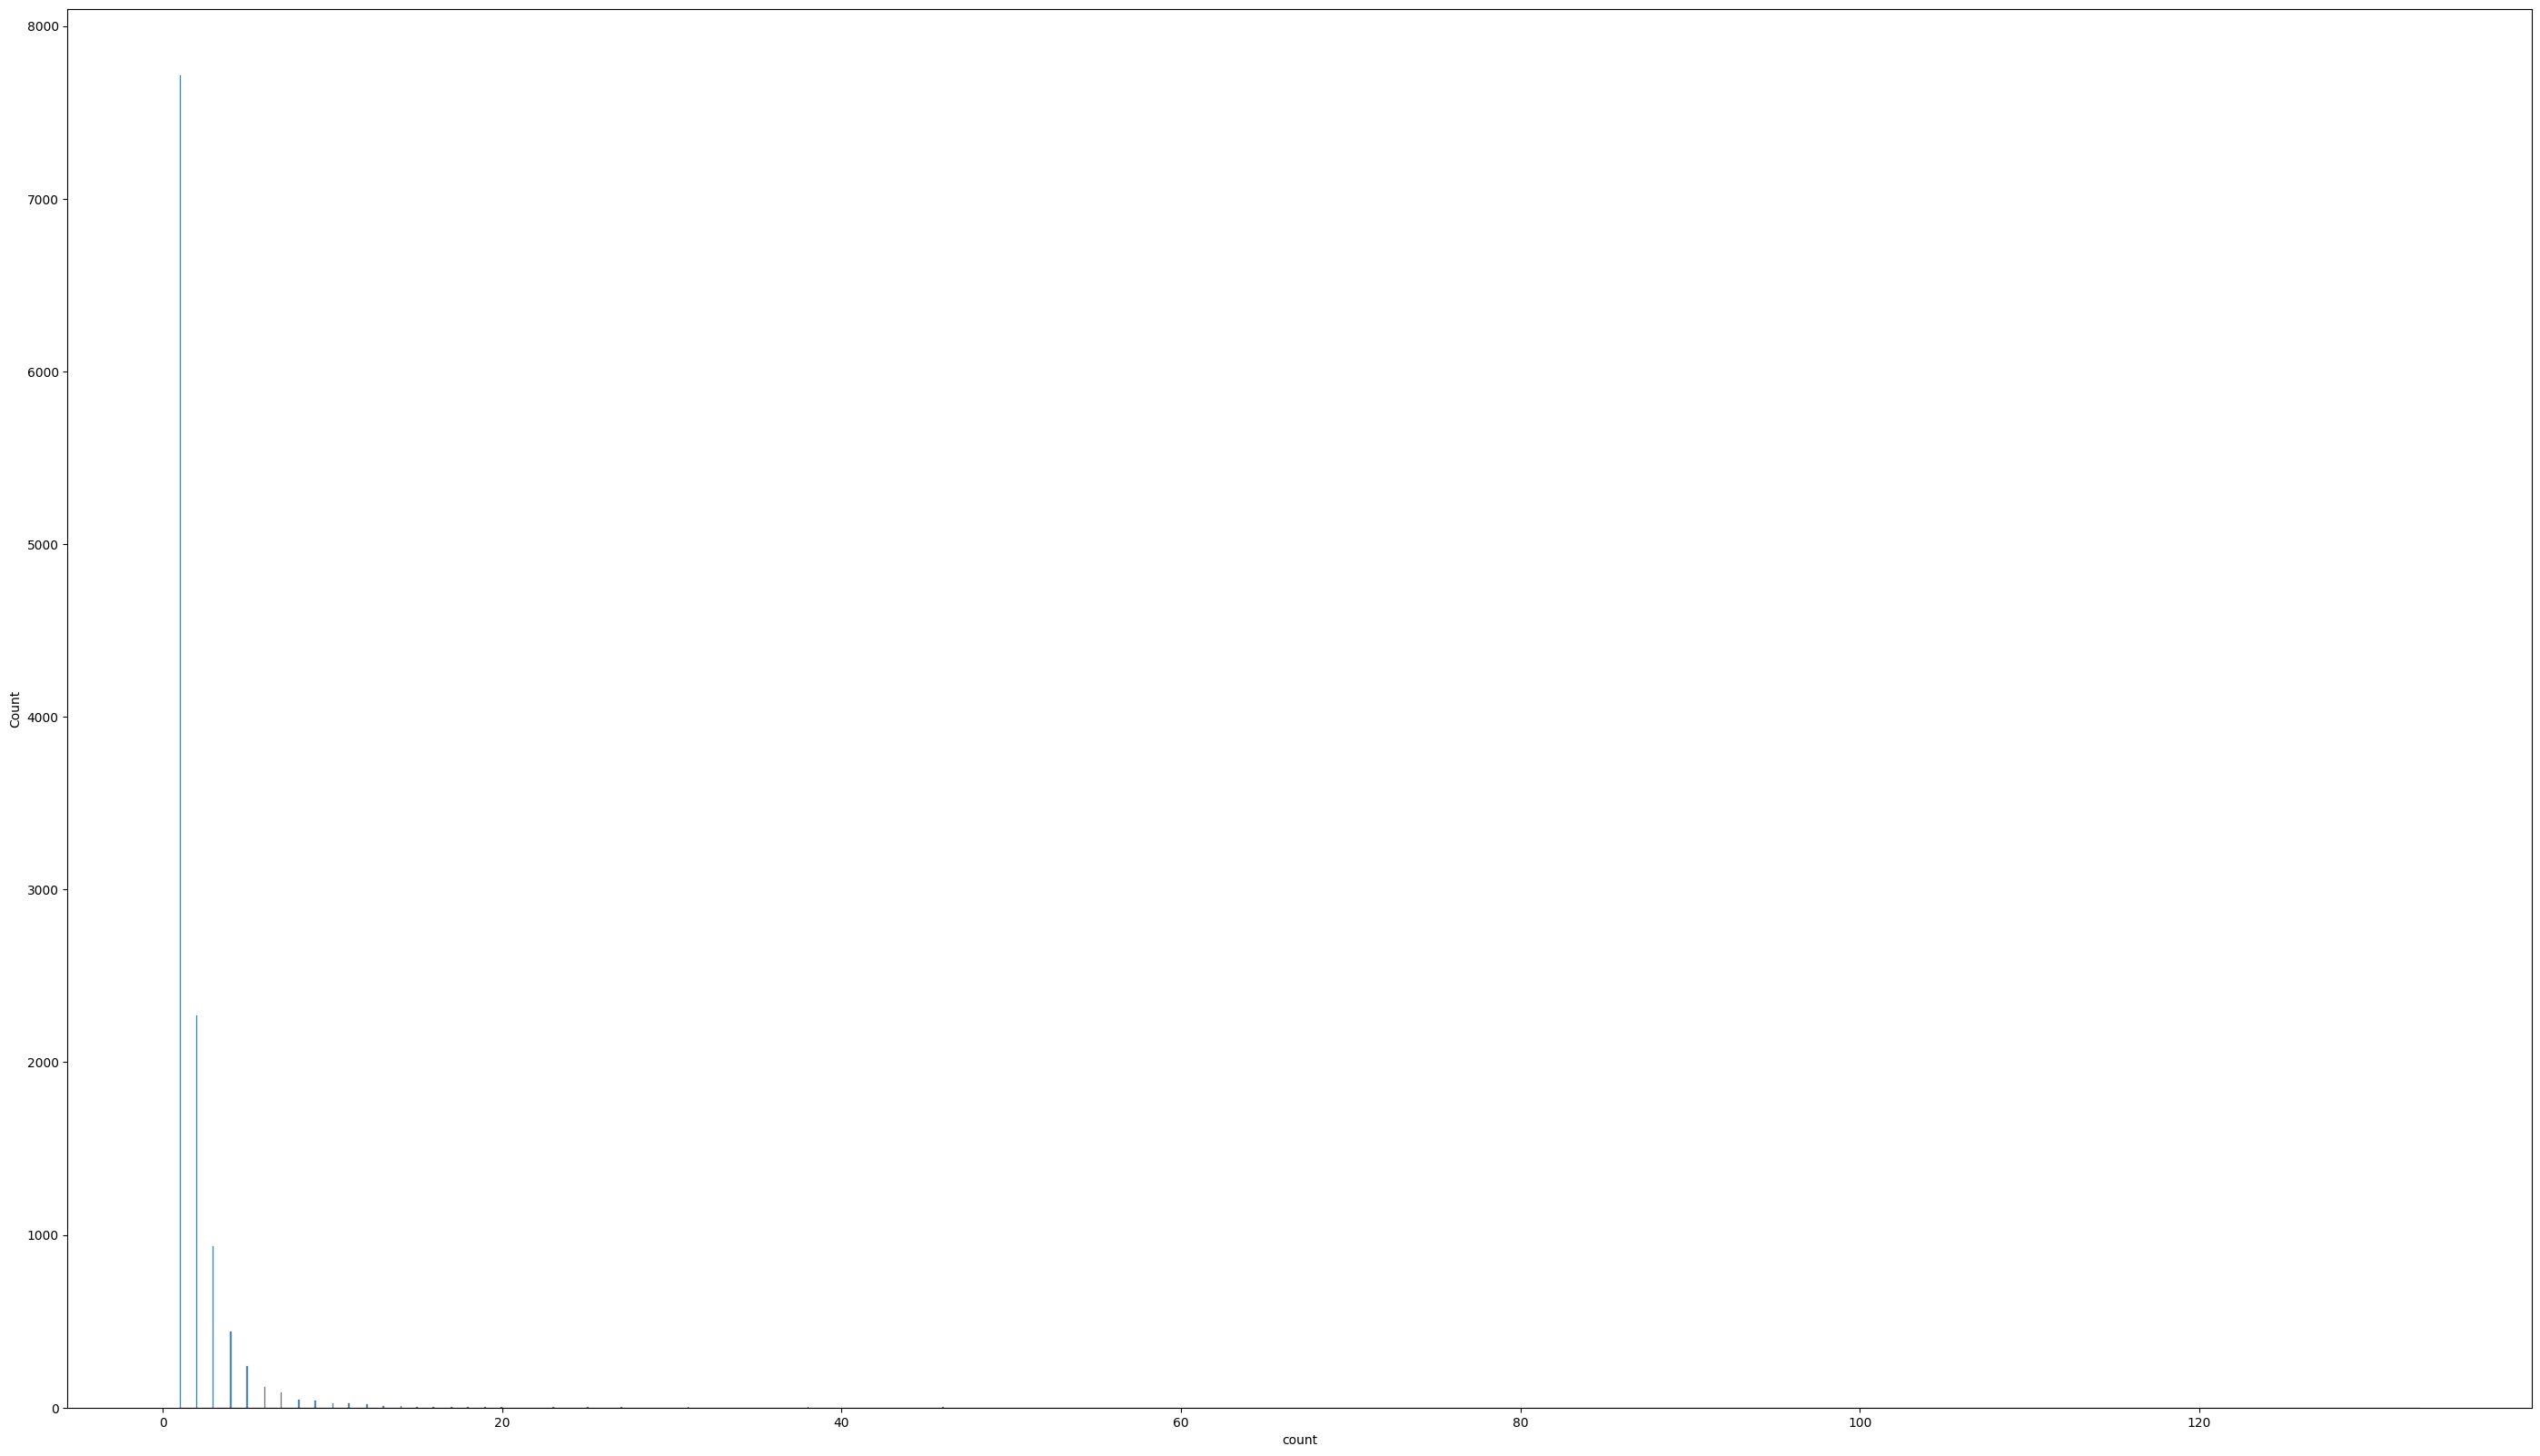

In [19]:
# Посмотрим гистрограмму распределения
fig, axes = plt.subplots(1, 1, figsize=(35, 20))
sns.histplot(item_transaction["count"], ax=axes)

plt.show()

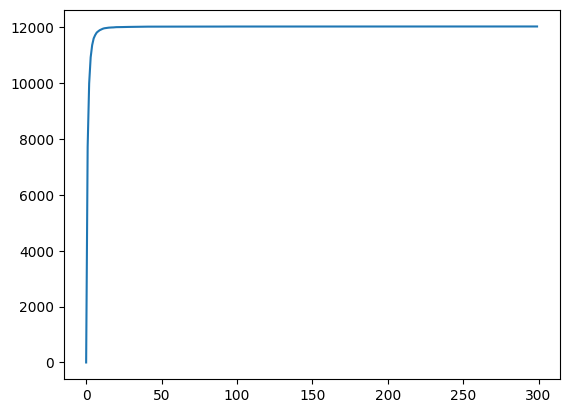

In [20]:
# Визуализируем диапазон в котором находится основная часть покупок по id
product_list = []
for i in range(300):
    product_list.append(item_transaction[item_transaction["count"] <= i].shape[0])

# Посмотрим переломный момент по покупкам
sns.lineplot(product_list)
plt.show()

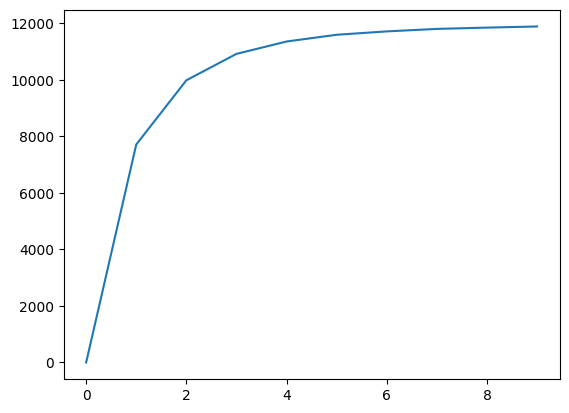

In [21]:
# Уменьшим скоуп для визуализации
product_list = []
for i in range(10):
    product_list.append(item_transaction[item_transaction["count"] <= i].shape[0])

# Посмотрим переломный момент по покупкам
sns.lineplot(product_list)
plt.show()

#### Можно видеть, ЗАПОЛНИТЬ

#### Предварительно ЗАПОЛНИТЬ

____

---

### Создадим функцию предобработки для events и проведем более глубокий EDA, попытавшись найти аномалии
### Данный обработчик мы будем использовать для классификации покупателей.

In [7]:
def events_reconstructor(raw_df: pd.DataFrame) -> pd.DataFrame:
    """Здесь будем производить всю предобработку и логику удаления аномальных данных
    если таковые имеются (опыт показал что имеются) и выведение итогового готового
    для моделирования датасета."""
    # One-hot
    raw_df = pd.concat([raw_df, pd.get_dummies(raw_df["event"], dtype=int)], axis=1)

    # Дроп ненужных фитов
    raw_df.drop(["transactionid", "event"], axis=1, inplace=True)

    # Вытащим час в который происходило взаимодействие
    raw_df["hour"] = raw_df["timestamp"].dt.hour

    # Нам нужно аггрегировать просмотры, транзакции и добавления в корзину
    raw_df["timestamp"] = raw_df["timestamp"].dt.date

    # Сформируем датафрейм содержащий количество просмотров, добавлений в корзину и покупок
    # в разрезе юзер-товар
    customers = (
        raw_df.groupby(by=["timestamp", "visitorid", "itemid", "hour"])[
            ["addtocart", "transaction", "view"]
        ]
        .sum()
        .reset_index()
    )

    # Восстановим тип для timestamp
    customers["timestamp"] = pd.to_datetime(customers["timestamp"])

    # Посмотрим были ли покупки без просмотров и добавлений в корзину,
    # по-сути это будут аномальные данные, при этом товары купленные без просмотра
    # или без добавления в корзину (только что-то одно) будут скорее сигнализировать
    # об импульсивности покупки
    customers["prob_anomaly"] = (
        customers["addtocart"] + customers["view"] - customers["transaction"]
    )

    customers["prob_anomaly"] = customers["prob_anomaly"].apply(
        lambda x: 0 if x >= 0 else 1
    )

    # Отсекаем все аномалии
    customers = customers[customers["prob_anomaly"] == 0]

    # Дропаем prob_anomaly, так как больше в ней нет нужды
    customers.drop(["prob_anomaly"], axis=1, inplace=True)

    # Будем исходить из того, что в будущем нам нужны данные для коллаборативной
    # фильтрации, а значит нам нужно сформировать фиты которые в последующем
    # помогут найти ближайшего соседа для которого уже известен товар с положительной
    # меткой класса таргет-переменной.

    # Начинаем feature engineering. Добавив сначала день недели в который было
    # произведено взаимодействие клиента с товаром
    customers["day_of_week"] = customers["timestamp"].dt.day_of_week

    # Выведем сумарное количество совершенных пользователем просмотров
    # Сначала создадим словарь с количеством просмотров по ID
    view_dict = customers.groupby("visitorid")["view"].sum().to_dict()
    customers["sum_views"] = customers["visitorid"].map(view_dict)

    # Сделаем то же самое для количества покупок и засовывания в корзину
    cart_dict = customers.groupby("visitorid")["addtocart"].sum().to_dict()
    customers["sum_carts"] = customers["visitorid"].map(cart_dict)

    trans_dict = customers.groupby("visitorid")["transaction"].sum().to_dict()
    customers["sum_trans"] = customers["visitorid"].map(trans_dict)

    return customers

In [23]:
# Обработаем events и посмотрим что получилось, по мере расследования
# будем добавлять функционал
customers = events_reconstructor(events)
customers.head()

,timestamp,visitorid,itemid,hour,addtocart,transaction,view,day_of_week,sum_views,sum_carts,sum_trans
0,2015-05-03,12,70225,15,0,0,1,6,1,0,0
1,2015-05-03,385,47324,5,0,0,1,6,1,0,0
2,2015-05-03,1250,112022,18,0,0,1,6,1,0,0
3,2015-05-03,1525,45559,17,0,0,1,6,1,0,0
4,2015-05-03,1701,120233,20,0,0,1,6,1,0,0


In [24]:
# Глянем сколько бинов можно сконструировать для определения лояльности клиента
# на основании распределений суммарных покупок, просмотров и добавлений (для
# хоть какой-то видимости будем смотреть %)
customers["sum_trans"].value_counts(normalize=True).sort_index()

sum_trans
0      0.943493
1      0.017385
2      0.006380
3      0.002187
4      0.002132
         ...   
172    0.000580
183    0.000649
260    0.001273
309    0.000803
529    0.002171
Name: proportion, Length: 69, dtype: float64

In [25]:
customers["sum_carts"].value_counts(normalize=True).sort_index()

sum_carts
0      0.887499
1      0.042558
2      0.013394
3      0.007099
4      0.005245
         ...   
231    0.000649
296    0.000442
371    0.000803
419    0.001273
719    0.002171
Name: proportion, Length: 97, dtype: float64

In [26]:
customers["sum_views"].value_counts(normalize=True).sort_index()

sum_views
0       0.001747
1       0.425890
2       0.151517
3       0.080993
4       0.050857
          ...   
2194    0.000689
2304    0.000803
2368    0.000843
3623    0.001273
6479    0.002171
Name: proportion, Length: 329, dtype: float64

> В основном ничего не покупают, только смотрят

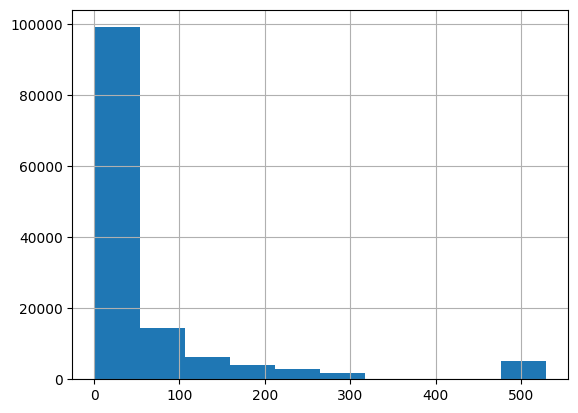

In [27]:
# Глянем распределения без гравитационных аномалий
customers["sum_trans"][customers["sum_trans"] > 0].hist()
plt.show()

Разобьем на 5 групп:

>0  покупок 

>1 - 10 покупок

>11 - 50 покупок

>51 - 100 покупок

>\> 100 покупок 

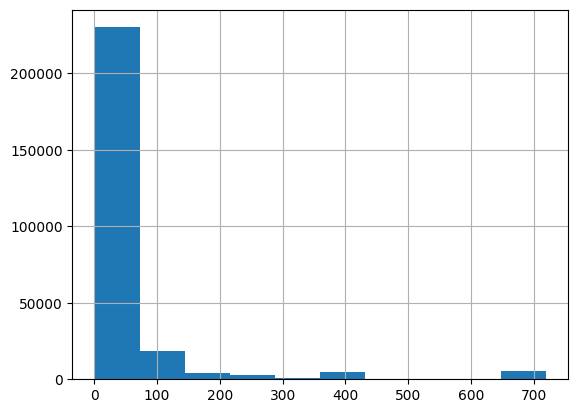

In [28]:
# Глянем распределения без гравитационных аномалий
customers["sum_carts"][customers["sum_carts"] > 0].hist()
plt.show()

Разобьем на 5 групп (картина распределения вполне ожидаемо похожа на распределение покупок):

>0  добавлений 

>1 - 10 добавлений

>11 - 50 добавлений

>51 - 100 добавлений

>\> 100 добавлений 

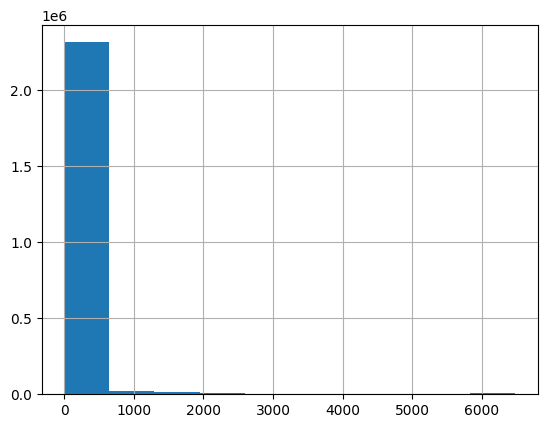

In [29]:
# Глянем распределения без гравитационных аномалий
customers["sum_views"][customers["sum_views"] > 0].hist()
plt.show()

In [30]:
# Функция для классификации добавлений в корзину и покупок
def trans_group(x):
    if x == 0:
        return 0
    elif 1 <= x < 10:
        return 1
    elif 10 <= x < 50:
        return 2
    elif 50 <= x < 100:
        return 3
    else:
        return 4

In [31]:
# Функция для классификации добавлений в корзину и покупок
def view_group(x):
    if x < 100:
        return 0
    elif 100 <= x < 200:
        return 1
    elif 200 <= x < 500:
        return 2
    elif 500 <= x < 1000:
        return 3
    else:
        return 4

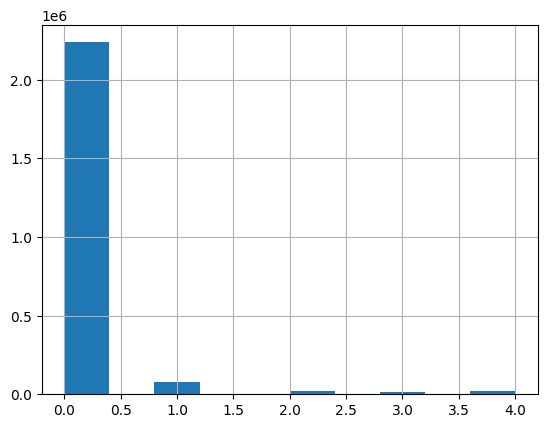

In [32]:
customers["transaction_bin"] = customers["sum_trans"].apply(trans_group)
customers["transaction_bin"].hist()
plt.show()

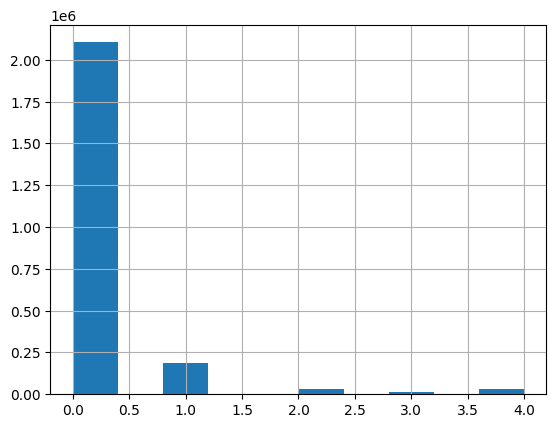

In [33]:
customers["carts_bin"] = customers["sum_carts"].apply(trans_group)
customers["carts_bin"].hist()
plt.show()

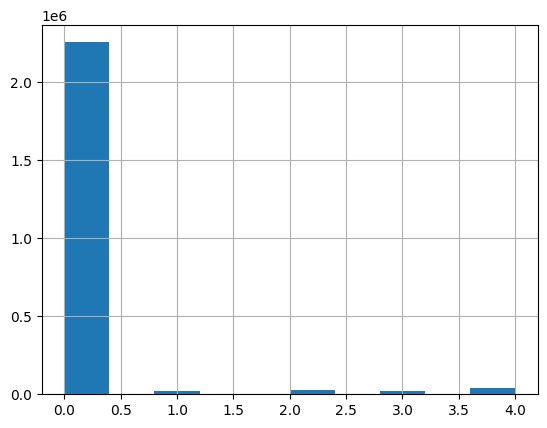

In [34]:
customers["view_bin"] = customers["sum_views"].apply(view_group)
customers["view_bin"].hist()
plt.show()

In [35]:
# Дропнем sum_views, sum_carts, sum_trans так как уже присвоили категорию
customers.drop(["sum_views", "sum_carts", "sum_trans"], axis=1, inplace=True)
customers.head()

,timestamp,visitorid,itemid,hour,addtocart,transaction,view,day_of_week,transaction_bin,carts_bin,view_bin
0,2015-05-03,12,70225,15,0,0,1,6,0,0,0
1,2015-05-03,385,47324,5,0,0,1,6,0,0,0
2,2015-05-03,1250,112022,18,0,0,1,6,0,0,0
3,2015-05-03,1525,45559,17,0,0,1,6,0,0,0
4,2015-05-03,1701,120233,20,0,0,1,6,0,0,0


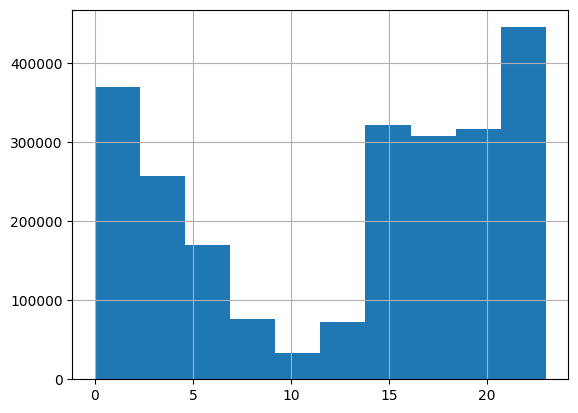

In [36]:
# Пришло время для кодификации времени
customers["hour"].hist()
plt.show()

Бьем на категории:

> 0 - 5 часов

> 5 - 10 часов

> 10 -15 часов

> 15 - 20 часов

> более 20

In [37]:
# Кодификация времени
def time_category(x):
    if 0 <= x < 5:
        return 1
    elif 5 <= x < 10:
        return 2
    elif 10 <= x < 15:
        return 3
    elif 15 <= x < 20:
        return 4
    else:
        return 5

In [38]:
customers["time_bin"] = customers["hour"].apply(time_category)
customers.drop(["hour"], axis=1, inplace=True)
customers.head()

,timestamp,visitorid,itemid,addtocart,transaction,view,day_of_week,transaction_bin,carts_bin,view_bin,time_bin
0,2015-05-03,12,70225,0,0,1,6,0,0,0,4
1,2015-05-03,385,47324,0,0,1,6,0,0,0,2
2,2015-05-03,1250,112022,0,0,1,6,0,0,0,4
3,2015-05-03,1525,45559,0,0,1,6,0,0,0,4
4,2015-05-03,1701,120233,0,0,1,6,0,0,0,5


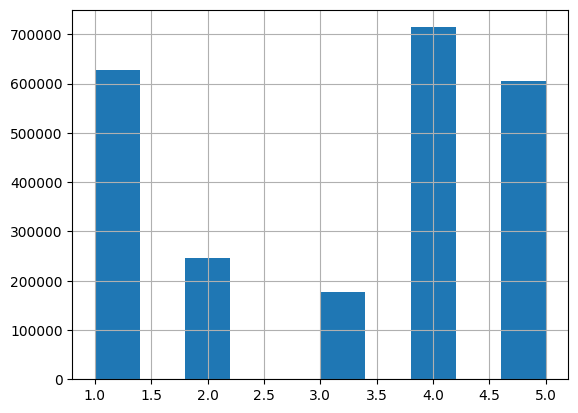

In [39]:
# Посмотрим на распределение после кодификации времени
customers["time_bin"].hist()
plt.show()

<Axes: >

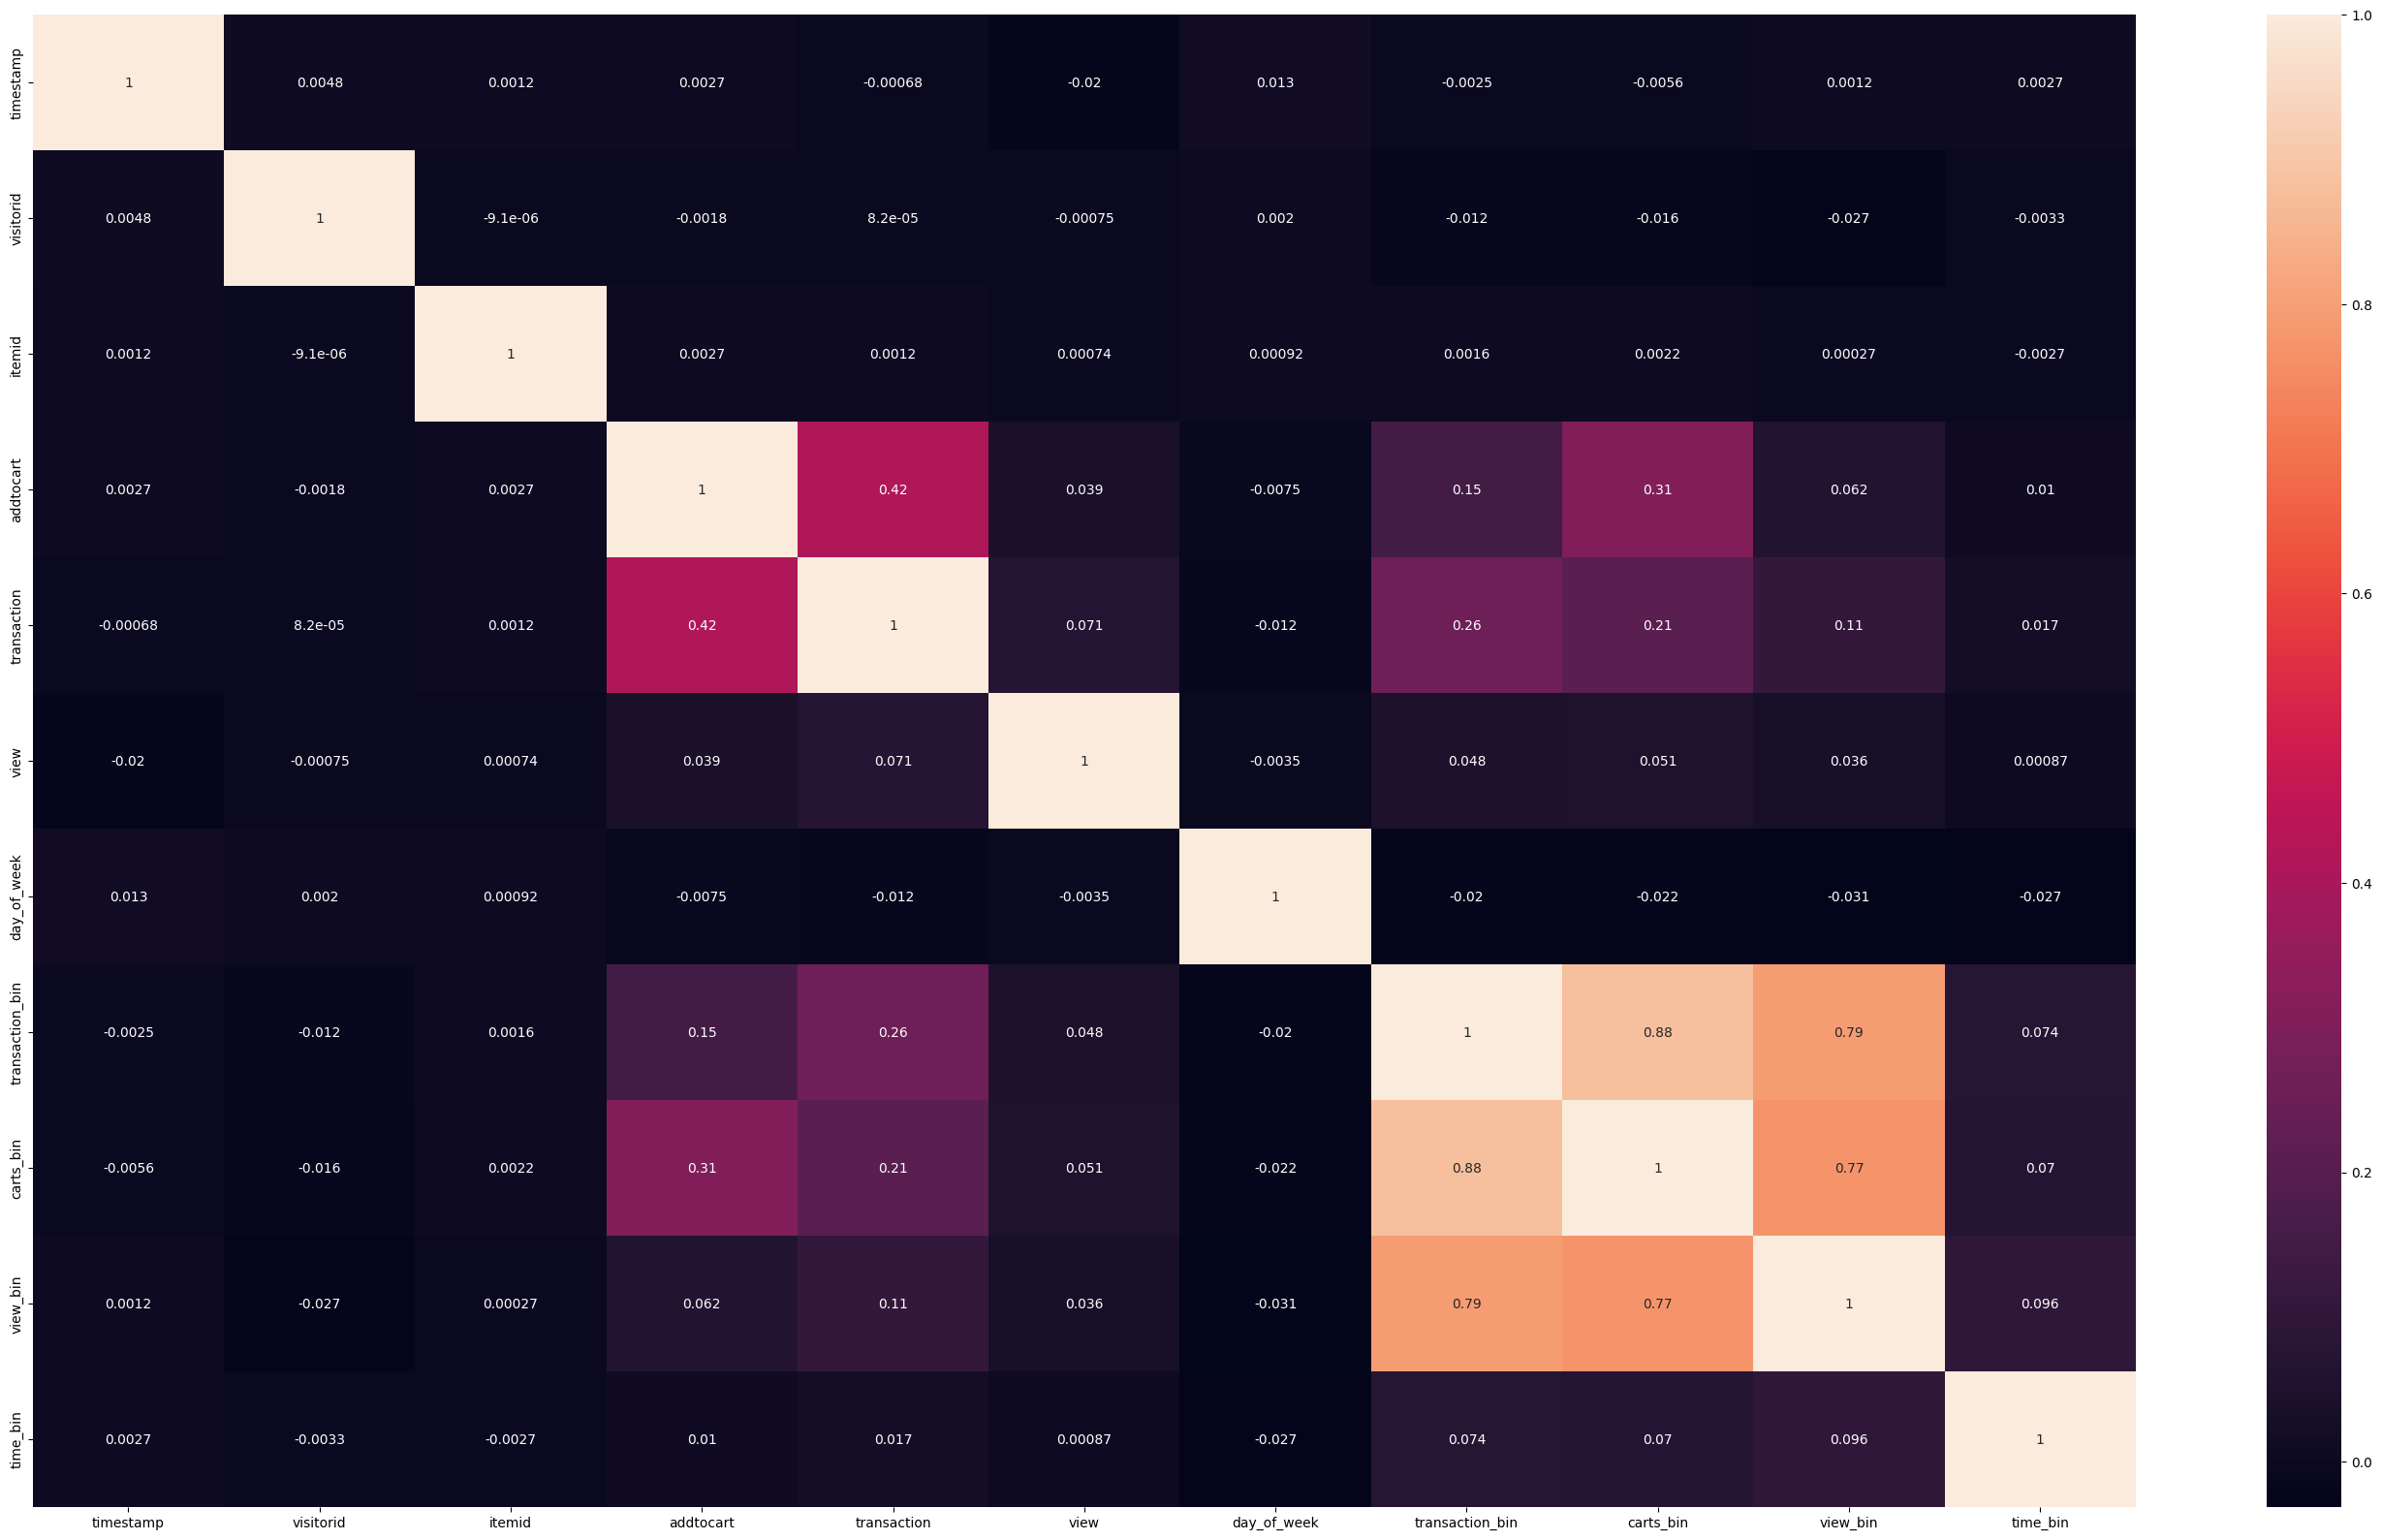

In [40]:
fig, axes = plt.subplots(1, 1, figsize=(35, 20))
sns.heatmap(customers.corr(), annot=True, ax=axes)

In [54]:
customers.query("transaction == 1")

,timestamp,visitorid,itemid,addtocart,transaction,view,day_of_week,transaction_bin,carts_bin,view_bin,time_bin
499,2015-05-03,53842,829,1,1,1,6,3,3,3,4
502,2015-05-03,53842,12404,1,1,1,6,3,3,3,4
505,2015-05-03,53842,45738,1,1,1,6,3,3,3,4
506,2015-05-03,53842,49881,1,1,2,6,3,3,3,4
512,2015-05-03,53842,90360,1,1,1,6,3,3,3,5
...,...,...,...,...,...,...,...,...,...,...,...
2374261,2015-09-18,427756,342659,1,1,3,4,1,1,0,1
2374408,2015-09-18,569539,389860,1,1,2,4,3,3,2,1
2374570,2015-09-18,751256,241715,1,1,0,4,1,1,0,1
2374936,2015-09-18,1156860,367900,1,1,1,4,1,1,0,1


### Дополним нашу функцию

In [19]:
def events_reconstructor(raw_df: pd.DataFrame) -> pd.DataFrame:
    """Здесь будем производить всю предобработку и логику удаления аномальных данных
    если таковые имеются (опыт показал что имеются) и выведение итогового готового
    для моделирования датасета."""

    raw_df["timestamp"] = pd.to_datetime(raw_df["timestamp"], unit="ms")

    # One-hot
    raw_df = pd.concat([raw_df, pd.get_dummies(raw_df["event"], dtype=int)], axis=1)

    # Дроп ненужных фитов
    raw_df.drop(["transactionid", "event"], axis=1, inplace=True)

    # Вытащим час в который происходило взаимодействие
    raw_df["hour"] = raw_df["timestamp"].dt.hour

    # Нам нужно аггрегировать просмотры, транзакции и добавления в корзину
    raw_df["timestamp"] = raw_df["timestamp"].dt.date

    # Сформируем датафрейм содержащий количество просмотров, добавлений в корзину и покупок
    # в разрезе юзер-товар
    customers = (
        raw_df.groupby(by=["timestamp", "visitorid", "itemid", "hour"])[
            ["addtocart", "transaction", "view"]
        ]
        .sum()
        .reset_index()
    )

    # Восстановим тип для timestamp
    customers["timestamp"] = pd.to_datetime(customers["timestamp"])

    # Посмотрим были ли покупки без просмотров и добавлений в корзину,
    # по-сути это будут аномальные данные, при этом товары купленные без просмотра
    # или без добавления в корзину (только что-то одно) будут скорее сигнализировать
    # об импульсивности покупки
    customers["prob_anomaly"] = (
        customers["addtocart"] + customers["view"] - customers["transaction"]
    )

    customers["prob_anomaly"] = customers["prob_anomaly"].apply(
        lambda x: 0 if x >= 0 else 1
    )

    # Отсекаем все аномалии
    customers = customers[customers["prob_anomaly"] == 0]

    # Дропаем prob_anomaly, так как больше в ней нет нужды
    customers.drop(["prob_anomaly"], axis=1, inplace=True)

    # Будем исходить из того, что в будущем нам нужны данные для коллаборативной
    # фильтрации, а значит нам нужно сформировать фиты которые в последующем
    # помогут найти ближайшего соседа для которого уже известен товар с положительной
    # меткой класса таргет-переменной.

    # Начинаем feature engineering. Добавив сначала день недели в который было
    # произведено взаимодействие клиента с товаром
    customers["day_of_week"] = customers["timestamp"].dt.day_of_week

    # Выведем сумарное количество совершенных пользователем просмотров
    # Сначала создадим словарь с количеством просмотров по ID
    view_dict = customers.groupby("visitorid")["view"].sum().to_dict()
    customers["sum_views"] = customers["visitorid"].map(view_dict)

    # Сделаем то же самое для количества покупок и засовывания в корзину
    cart_dict = customers.groupby("visitorid")["addtocart"].sum().to_dict()
    customers["sum_carts"] = customers["visitorid"].map(cart_dict)

    trans_dict = customers.groupby("visitorid")["transaction"].sum().to_dict()
    customers["sum_trans"] = customers["visitorid"].map(trans_dict)

    # Функция для классификации добавлений в корзину и покупок
    def trans_group(x):
        if x == 0:
            return 0
        elif 1 <= x < 10:
            return 1
        elif 10 <= x < 50:
            return 2
        elif 50 <= x < 100:
            return 3
        else:
            return 4

    # Функция для классификации добавлений в корзину и покупок
    def view_group(x):
        if x < 100:
            return 0
        elif 100 <= x < 200:
            return 1
        elif 200 <= x < 500:
            return 2
        elif 500 <= x < 1000:
            return 3
        else:
            return 4

    # Кодификация времени
    def time_category(x):
        if 0 <= x < 5:
            return 1
        elif 5 <= x < 10:
            return 2
        elif 10 <= x < 15:
            return 3
        elif 15 <= x < 20:
            return 4
        else:
            return 5

    customers["transaction_bin"] = customers["sum_trans"].apply(trans_group)
    customers["carts_bin"] = customers["sum_carts"].apply(trans_group)
    customers["view_bin"] = customers["sum_views"].apply(view_group)

    # Дропнем sum_views, sum_carts, sum_trans так как уже присвоили категорию
    customers.drop(["sum_views", "sum_carts", "sum_trans"], axis=1, inplace=True)

    customers["time_bin"] = customers["hour"].apply(time_category)
    customers.drop(["hour"], axis=1, inplace=True)

    # Редуцируем таргет до 2 классов
    customers["transaction"] = customers["transaction"].apply(
        lambda x: 0 if x == 0 else 1
    )

    # Так же поступим с просмотром и добавлением в корзину, идея в том, что
    # данные по просмотрам и добавлнеиям в контексте харакхтеристики присущей пользователям
    # мы уже закинули в бины отражающие взаимосвязь клиент-товар-поведение (но может это
    # и не обоснованное предположение)

    customers["addtocart"] = customers["addtocart"].apply(lambda x: 0 if x == 0 else 1)
    customers["view"] = customers["view"].apply(lambda x: 0 if x == 0 else 1)

    # One-hot на всех бинах
    customers = pd.get_dummies(
        customers,
        columns=["transaction_bin", "carts_bin", "view_bin", "time_bin", "day_of_week"],
        dtype=int,
    )

    # customers.drop(
    #    ["transaction_bin", "carts_bin", "view_bin", "time_bin", "day_of_week"],
    #    axis=1,
    #    inplace=True,
    # )

    # Скинем думбликаты
    customers.drop_duplicates(inplace=True)

    return customers

In [4]:
# Протестируем
customers = events_reconstructor(events)

<Axes: >

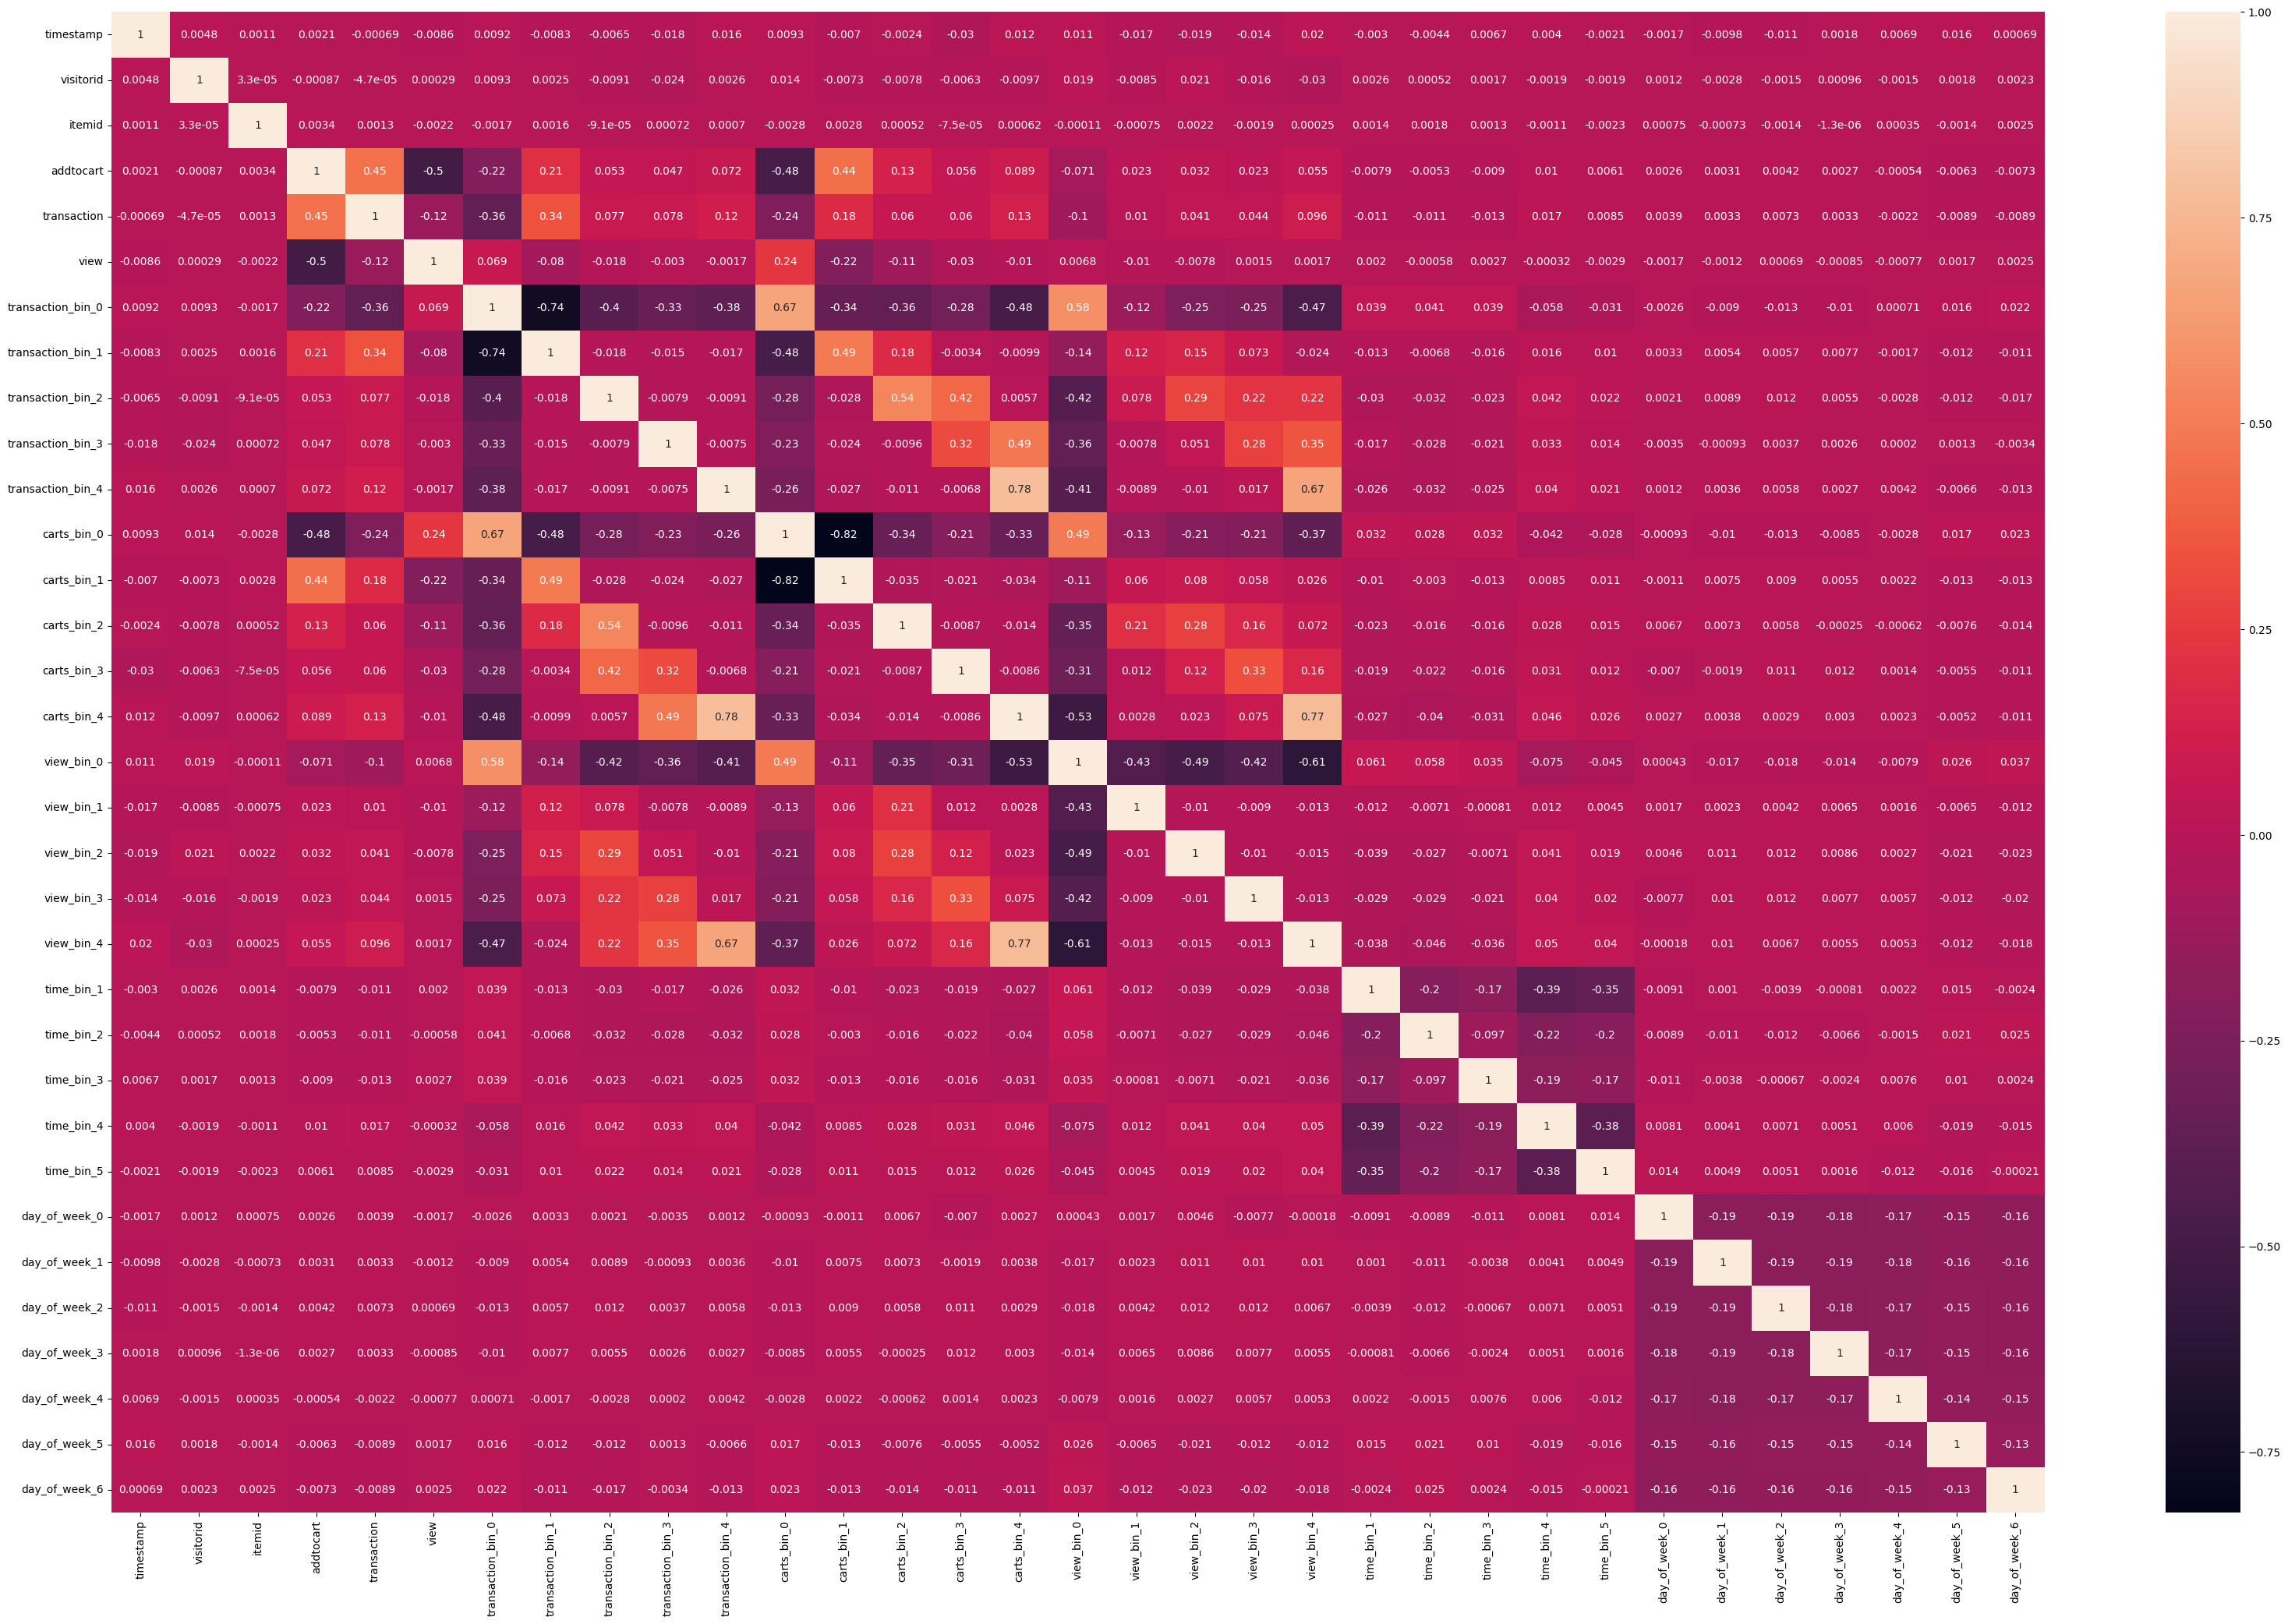

In [69]:
# Глянем на мультиколлинеарность
fig, axes = plt.subplots(1, 1, figsize=(40, 25))
sns.heatmap(customers.corr(), annot=True, ax=axes)

> Красивое, но есть подозрение что ряд параметров попадает под мультиколлинеарность

In [5]:
customers.head()

,timestamp,visitorid,itemid,addtocart,transaction,view,transaction_bin_0,transaction_bin_1,transaction_bin_2,transaction_bin_3,...,time_bin_3,time_bin_4,time_bin_5,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,2015-05-03,12,70225,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,2015-05-03,385,47324,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2015-05-03,1250,112022,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,2015-05-03,1525,45559,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,2015-05-03,1701,120233,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


> Получили sparce-матрицу которая по-идее может помочь стратифицировать покупателей на несколько групп:
> 1. Покупатели, которые готовы купить хоть что-то
> 2. Покупатели, которые зашли посмотреть (для них можно применять рекомендацию самых продаваемых товаров например)

#### А что если нам попытаться создать матрицу "похожести пользователей"? Идея такая, группируем  всех пользователей по id оставляя фиты взаимодействия с ресурсом и внутренние характеристики пользователя.

In [126]:
def customer_similarity(raw_df: pd.DataFrame) -> pd.DataFrame:
    raw_df["timestamp"] = pd.to_datetime(raw_df["timestamp"], unit="ms")

    # One-hot
    raw_df = pd.concat([raw_df, pd.get_dummies(raw_df["event"], dtype=int)], axis=1)

    # Дроп ненужных фитов
    raw_df.drop(["transactionid", "event"], axis=1, inplace=True)

    # Вытащим час в который происходило взаимодействие
    raw_df["hour"] = raw_df["timestamp"].dt.hour

    # Добавим день недели
    raw_df["day_of_week"] = raw_df["timestamp"].dt.day_of_week

    # Сгруппируем
    customers = (
        raw_df.groupby(by=["visitorid"])
        .agg(
            {
                "addtocart": "sum",
                "transaction": "sum",
                "view": "sum",
                "hour": lambda x: x.mode().iloc[0],
                "day_of_week": lambda x: x.mode().iloc[0],
            }
        )
        .reset_index()
    )

    # Функция для классификации добавлений в корзину и покупок
    def trans_group(x):
        if x == 0:
            return 0
        elif 1 <= x < 10:
            return 1
        elif 10 <= x < 50:
            return 2
        elif 50 <= x < 100:
            return 3
        else:
            return 4

    # Функция для классификации добавлений в корзину и покупок
    def view_group(x):
        if x < 100:
            return 0
        elif 100 <= x < 200:
            return 1
        elif 200 <= x < 500:
            return 2
        elif 500 <= x < 1000:
            return 3
        else:
            return 4

    # Кодификация времени
    def time_category(x):
        if 0 <= x < 5:
            return 1
        elif 5 <= x < 10:
            return 2
        elif 10 <= x < 15:
            return 3
        elif 15 <= x < 20:
            return 4
        else:
            return 5

    customers["transaction_bin"] = customers["transaction"].apply(trans_group)
    customers["carts_bin"] = customers["addtocart"].apply(trans_group)
    customers["view_bin"] = customers["view"].apply(view_group)
    customers["time_bin"] = customers["hour"].apply(time_category)
    customers.drop(["hour"], axis=1, inplace=True)

    # customers = customers.drop(columns=["addtocart", "transaction", "view"])
    customers["transaction"] = customers["transaction"].apply(
        lambda x: 1 if x > 0 else 0
    )

    # Создаем вектор признаков присущих id
    customers["feats"] = customers.iloc[:, 3:].apply(
        lambda row: " ".join(map(str, row)), axis=1
    )

    customers["feats"] = customers["feats"].str.split(" ")

    return customers

In [127]:
test = events[events["timestamp"] <= "2015-07-01"]
test = customer_similarity(test)

In [128]:
test

,visitorid,addtocart,transaction,view,day_of_week,transaction_bin,carts_bin,view_bin,time_bin,feats
0,7,0,0,3,3,0,0,0,2,"[3, 3, 0, 0, 0, 2]"
1,8,0,0,1,6,0,0,0,1,"[1, 6, 0, 0, 0, 1]"
2,12,0,0,1,6,0,0,0,4,"[1, 6, 0, 0, 0, 4]"
3,13,0,0,2,3,0,0,0,1,"[2, 3, 0, 0, 0, 1]"
4,14,0,0,1,3,0,0,0,4,"[1, 3, 0, 0, 0, 4]"
...,...,...,...,...,...,...,...,...,...,...
606758,1407575,0,0,1,2,0,0,0,5,"[1, 2, 0, 0, 0, 5]"
606759,1407576,0,0,1,2,0,0,0,4,"[1, 2, 0, 0, 0, 4]"
606760,1407577,0,0,1,6,0,0,0,5,"[1, 6, 0, 0, 0, 5]"
606761,1407578,0,0,1,6,0,0,0,1,"[1, 6, 0, 0, 0, 1]"


> Тут мы получили датафрейм содержащий id пользователей и их характеристики за интересующий период, при этом в столбце feats мы видим вектор характеризующий пользователя, что может быть полезным для поиска ближайшего соседа, а остальные столбцы - позволят классифицировать покупателя как активного или пассивного.

----

### Теперь на основе датасета events нам нужно создать обработчик для content-based подхода (попбробуем реализовать функционал подготовки для USER-BASED, ITEM-BASED(просто транспонируем предудущее) и MODEL-BASED)

In [93]:
# Здесь используем сразу точку отскчения
temp = events[events["timestamp"] <= "2015-07-01"]

# Дропнем transactionid так как она малоинформативна
temp = temp.drop(columns=["transactionid"])

# Перекодируем вид взаимодействия с товаром
# Расставим веса не линейно, что бы тянуть в сторону транзакций
temp["score"] = temp["event"].map({"view": 0.1, "addtocart": 6, "transaction": 9})

# Получим id товаров которые покупались
purchased = temp[temp["event"] == "transaction"]["itemid"].unique()

display(temp.head())
print(len(purchased))

,timestamp,visitorid,event,itemid,score
0,2015-06-02 05:02:12.117,257597,view,355908,0.1
1,2015-06-02 05:50:14.164,992329,view,248676,0.1
2,2015-06-02 05:13:19.827,111016,view,318965,0.1
3,2015-06-02 05:12:35.914,483717,view,253185,0.1
4,2015-06-02 05:02:17.106,951259,view,367447,0.1


6231


In [94]:
# Выделим товары которые были куплены с сохранением всех взаимодействий с ними (лень объяснять)
temp = temp.query("itemid in @purchased")
display(
    temp.head(),
    temp.tail(),
    temp.shape
)

,timestamp,visitorid,event,itemid,score
1,2015-06-02 05:50:14.164,992329,view,248676,0.1
6,2015-06-02 05:12:03.240,810725,view,443030,0.1
10,2015-06-02 05:16:02.373,176446,view,10572,0.1
19,2015-06-02 04:57:58.505,158090,addtocart,10572,6.0
22,2015-06-02 05:01:14.809,1213673,view,343861,0.1


,timestamp,visitorid,event,itemid,score
2059435,2015-06-01 03:38:39.753,1224025,view,301531,0.1
2059439,2015-06-01 03:49:00.091,888356,view,65286,0.1
2059452,2015-06-01 04:14:08.462,194125,view,133814,0.1
2059453,2015-06-01 04:43:19.527,886166,transaction,234431,9.0
2059455,2015-06-01 04:04:48.480,1135401,view,59508,0.1


(312799, 5)

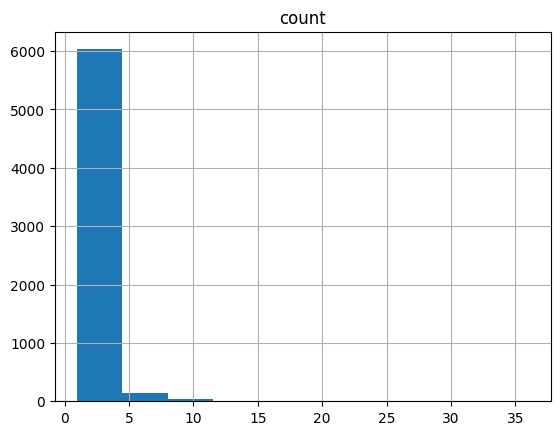

In [95]:
# Посмотрим как распределяется покупка товаров
top_items = pd.DataFrame(
    temp.query("event == 'transaction'").groupby("itemid").value_counts()
).reset_index()

top_items = pd.DataFrame(top_items.groupby("itemid")["count"].sum())
top_items.hist()
plt.show()

> Можно видеть, что в основном товары покупаются разово, нам нужно вытянуть товары у которых есть некоторая системность

In [96]:
# Создадим список по которому будем брать более-менее нужные товары
transaction_id_list = top_items.query("count > 5").reset_index()["itemid"].to_list()
len(transaction_id_list)


119

> Мы получили 119 ходовых товаров, по которым мы можем заключить что это были не разовые покупки и есть некая системность для рекомендации.

In [100]:
# Оставим взаимодействие по ходовым товарам
cust_items = temp.query("itemid in @transaction_id_list").reset_index(drop=True)
cust_items.drop_duplicates(inplace=True)

display(
    cust_items.head(),
    cust_items.tail(),
    cust_items.shape
)

,timestamp,visitorid,event,itemid,score
0,2015-06-02 05:42:56.925,969887,view,159780,0.1
1,2015-06-02 04:58:07.074,794013,view,51354,0.1
2,2015-06-02 05:59:42.317,239546,view,42002,0.1
3,2015-06-02 05:10:46.073,870742,view,234255,0.1
4,2015-06-02 04:54:40.956,105775,addtocart,312728,6.0


,timestamp,visitorid,event,itemid,score
30368,2015-06-01 02:02:42.071,1314472,addtocart,409804,6.0
30369,2015-06-01 02:16:24.663,645326,view,7943,0.1
30371,2015-06-01 04:44:29.754,705492,view,42002,0.1
30372,2015-06-01 03:46:51.238,391801,view,315543,0.1
30373,2015-06-01 04:52:29.242,507833,view,46156,0.1


(30368, 5)

In [101]:
pivot = cust_items.pivot_table(
    index="visitorid",
    columns="itemid",
    values="score",
    aggfunc="sum",
    fill_value=0,
)
pivot

itemid,7943,12217,16344,17478,19883,23762,29196,41803,42002,46156,...,442131,446522,448453,448494,448601,450082,454818,456056,460553,461686
visitorid,,,,,,,,,,,,,,,,,,,,,
180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0
512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1407249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1407397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> Теперь у нас есть матрица взаимодействий c товарами с очисткой от шума разовых покупок (или околоразовых) теперь нужно все это обернуть в функцию.

In [104]:
def user_item(
    raw_df: pd.DataFrame, time_border: str = None, lower: bool = True
) -> pd.DataFrame:
    # Фильтрация на основе time_border и lower
    if time_border is not None and lower:
        temp = raw_df[raw_df["timestamp"] <= time_border]
    elif time_border is not None and not lower:
        temp = raw_df[raw_df["timestamp"] > time_border]
    else:
        temp = raw_df.copy()

    # Дропнем transactionid так как она малоинформативна
    temp = temp.drop(columns=["transactionid"])

    # Перекодируем вид взаимодействия с товаром
    # Расставим веса не линейно, что бы тянуть в сторону транзакций
    temp["score"] = temp["event"].map({"view": 0.1, "addtocart": 6, "transaction": 9})

    # Получим id товаров которые покупались
    purchased = temp[temp["event"] == "transaction"]["itemid"].unique()

    # Выделим товары которые были куплены с сохранением всех взаимодействий с ними (лень объяснять)
    temp = temp.query("itemid in @purchased")

    # Посмотрим как распределяется покупка товаров
    top_items = pd.DataFrame(
        temp.query("event == 'transaction'").groupby("itemid").value_counts()
    ).reset_index()

    top_items = pd.DataFrame(top_items.groupby("itemid")["count"].sum())

    # Создадим список по которому будем брать более-менее нужные товары
    transaction_id_list = top_items.query("count > 5").reset_index()["itemid"].to_list()

    cust_items = temp.query("itemid in @transaction_id_list").reset_index(drop=True)
    cust_items.drop_duplicates(inplace=True)

    pivot = cust_items.pivot_table(
        index="visitorid",
        columns="itemid",
        values="score",
        aggfunc="sum",
        fill_value=0,
    )

    return pivot

In [105]:
# Проверим как работает наша функция
check = user_item(events, time_border="2015-07-01")
check

itemid,7943,12217,16344,17478,19883,23762,29196,41803,42002,46156,...,442131,446522,448453,448494,448601,450082,454818,456056,460553,461686
visitorid,,,,,,,,,,,,,,,,,,,,,
180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0
512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1407249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1407397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> Вроде работает. В ней реализован функционал по отсечению старых и новых данных, что важно при формировании валидационной выборки.

---

### Поработаем с датафреймами item_properties и category_tree

In [28]:
# Создаем функцию для обработки на стороне микросервиса
def items_reconstructor(raw_df: pd.DataFrame, cat_df: pd.DataFrame) -> pd.DataFrame:
    # Поработаем со свойствами товаров, сначала приведем property к int64,
    # как было указано в property лежат категории + хеши остальных свойств,
    # следовательно переведя в числовой формат и перехватив ошибку в нан мы должны
    # оставить только категории.

    item_properties = raw_df

    item_properties["timestamp"] = pd.to_datetime(
        item_properties["timestamp"], unit="ms"
    )

    item_properties["property"] = pd.to_numeric(
        item_properties["property"], errors="coerce"
    )

    # Удалим пропуски
    item_properties.dropna(inplace=True)

    # Переименуем property в categoryid
    item_properties.rename(columns={"property": "categoryid"}, inplace=True)

    # Добавим свойство родительской категории из фрейма category_tree
    item_properties = pd.merge(
        left=item_properties,
        right=cat_df,
        left_on="categoryid",
        right_on="categoryid",
    )

    # Удалим временную метку
    item_properties.drop(["timestamp"], axis=1, inplace=True)

    # Токенезируем value и переименуем во что-то более вразумительное
    items = item_properties.rename(columns={"value": "charac"})

    # Создадим функцию для токенизации
    def item_prop_tokenizer(prop):
        prop = prop.replace("n", "")
        numeric_list = []
        for x in prop.split():
            try:
                numeric_list.append(float(x))
            except ValueError:
                numeric_list.append(float(0))
        return numeric_list

    items["charac"] = items["charac"].apply(item_prop_tokenizer)

    return items

In [29]:
# Посмотрим что получилось
items = items_reconstructor(item_properties, category_tree)

In [30]:
items

,itemid,categoryid,charac,parentid
0,206783,888.0,"[1116713.0, 960601.0, 277.2]",866.0
1,395014,400.0,"[552.0, 639502.0, 720.0, 424566.0]",110.0
2,59481,790.0,[15360.0],1492.0
3,156781,917.0,[828513.0],1374.0
4,89534,213.0,[1121373.0],1299.0
...,...,...,...,...
17873741,236931,929.0,[12.0],1027.0
17873742,455746,6.0,"[150169.0, 639134.0]",933.0
17873743,347565,686.0,[610834.0],594.0
17873744,287231,867.0,[769062.0],441.0


In [31]:
temp = pd.DataFrame(
    items.groupby(["itemid", "categoryid", "parentid"])["charac"].agg(list)
)

In [32]:
temp.reset_index()

,itemid,categoryid,parentid,charac
0,0,6.0,933.0,"[[1152934.0, 1238769.0], [1152934.0, 1238769.0..."
1,0,11.0,1439.0,"[[15360.0, 628176.0, 12288.0]]"
2,0,42.0,170.0,[[204.0]]
3,0,112.0,381.0,[[679677.0]]
4,0,127.0,312.0,[[1168476.0]]
...,...,...,...,...
11055165,466866,876.0,580.0,"[[1322342.0, 945042.0, 150169.0, 1252290.0]]"
11055166,466866,886.0,1486.0,[[769062.0]]
11055167,466866,888.0,866.0,"[[892415.0, 670753.0, 114844.0, 808585.0]]"
11055168,466866,896.0,55.0,[[769062.0]]


> А получилось что один и тот же itemid может принадлежать разным категориям с разными свойствами. посмотрим являются ли свойства характерной чертой для категории, и если так то весьма упростит нам жизнь.

In [33]:
temp.query("categoryid == 6")

,,,charac
itemid,categoryid,parentid,
0,6.0,933.0,"[[1152934.0, 1238769.0], [1152934.0, 1238769.0..."
1,6.0,933.0,[[1020281.0]]
3,6.0,933.0,[[1305767.0]]
4,6.0,933.0,"[[588652.0, 1091491.0]]"
5,6.0,933.0,"[[188678.0, 316731.0, 30603.0, 341599.0]]"
...,...,...,...
466862,6.0,933.0,[[1102430.0]]
466863,6.0,933.0,"[[823435.0, 945042.0]]"
466864,6.0,933.0,[[21558.0]]


In [34]:
temp.query("itemid == 0")

charac
itemid categoryid parentid                                                   
0      6.0        933.0     [[1152934.0, 1238769.0], [1152934.0, 1238769.0...
       11.0       1439.0                       [[15360.0, 628176.0, 12288.0]]
       42.0       170.0                                             [[204.0]]
       112.0      381.0                                          [[679677.0]]
       127.0      312.0                                         [[1168476.0]]
       139.0      585.0                        [[4800.0, 270060.0, 924073.0]]
       159.0      1028.0                                         [[519769.0]]
       177.0      768.0                                   [[96.0, 1206660.0]]
       189.0      586.0                                          [[708480.0]]
       202.0      1008.0                                         [[478989.0]]
       225.0      593.0                                         [[1301326.0]]
       227.0      602.0                              [[1152934.0, 1238769.0]]
       283.0      1579.0                      [[66094.0, 372274.0, 478989.0]]
       364.0      711.0                                           [[20716.0]]
       561.0      395.0                               [[1294803.0, 101489.0]]
       678.0      250.0                                          [[372274.0]]
       698.0      1251.0                             [[1152934.0, 1238769.0]]
       764.0      1370.0                                        [[1285872.0]]
       776.0      727.0                                          [[318611.0]]
       790.0      1492.0                                          [[91200.0]]
       839.0      33.0                                           [[372274.0]]
       869.0      679.0                                          [[769062.0]]
       888.0      866.0                                          [[478989.0]]
       917.0      1374.0                                         [[478989.0]]
       1036.0     1420.0                                        [[1276750.0]]
       1056.0     1579.0                                 [[3.168, 1144008.0]]

> Можно заметить, что характеристика товар внутри категорий не совпадает, и внутри id тоже, можно сказать, что характеристика товара зашивает в себя уникальное сочетание idтовара и его категорий.

In [35]:
temp_2 = pd.DataFrame(items.groupby(["itemid"])["charac"].agg(list))

In [36]:
temp_2

,charac
itemid,
0,"[[679677.0], [66094.0, 372274.0, 478989.0], [1..."
1,"[[866110.0], [769062.0], [814966.0], [1128577...."
2,"[[192.0, 145688.0], [72.0], [519769.0], [82209..."
3,"[[519769.0], [327918.0], [769062.0], [138228.0..."
4,"[[24.0], [324209.0], [150169.0, 176547.0], [50..."
...,...
466862,"[[769062.0], [519769.0], [1102430.0], [1285872..."
466863,"[[43320.0], [204.0], [1075463.0], [1159.0], [2..."
466864,"[[81000.0], [1298303.0], [105000.0], [129600.0..."


In [37]:
# Создадим сет характеристик для каждого id товара
def remove_empty_and_none(x):
    if x is None or x == "":
        return None
    else:
        flattened_array = np.concatenate(x)
        return set(flattened_array) if flattened_array.size > 0 else None


temp_2["uniq"] = temp_2["charac"].apply(remove_empty_and_none)

In [38]:
temp_2

,charac,uniq
itemid,,
0,"[[679677.0], [66094.0, 372274.0, 478989.0], [1...","{708480.0, 15360.0, 12288.0, 3.168, 1206660.0,..."
1,"[[866110.0], [769062.0], [814966.0], [1128577....","{5760.0, 1128577.0, 302848.0, 435459.0, 190728..."
2,"[[192.0, 145688.0], [72.0], [519769.0], [82209...","{1081984.0, 1128577.0, 325894.0, 396934.0, 636..."
3,"[[519769.0], [327918.0], [769062.0], [138228.0...","{769062.0, 1305767.0, 1182824.0, 261419.0, 327..."
4,"[[24.0], [324209.0], [150169.0, 176547.0], [50...","{819329.0, 1128577.0, 1142657.0, 71429.0, 4683..."
...,...,...
466862,"[[769062.0], [519769.0], [1102430.0], [1285872...","{443786.0, 717323.0, 12.0, 274.8, 286484.0, 15..."
466863,"[[43320.0], [204.0], [1075463.0], [1159.0], [2...","{386817.0, 1159.0, 1075463.0, 224903.0, 581001..."
466864,"[[81000.0], [1298303.0], [105000.0], [129600.0...","{105600.0, 1128577.0, 1071492.0, 396934.0, 114..."


In [3]:
# Теперь обновим нашу функцию
def items_reconstructor(raw_df: pd.DataFrame, cat_df: pd.DataFrame) -> pd.DataFrame:
    # Поработаем со свойствами товаров, сначала приведем property к int64,
    # как было указано в property лежат категории + хеши остальных свойств,
    # следовательно переведя в числовой формат и перехватив ошибку в нан мы должны
    # оставить только категории.

    item_properties = raw_df

    item_properties["timestamp"] = pd.to_datetime(
        item_properties["timestamp"], unit="ms"
    )

    item_properties["property"] = pd.to_numeric(
        item_properties["property"], errors="coerce"
    )

    # Удалим пропуски
    item_properties.dropna(inplace=True)

    # Переименуем property в categoryid
    item_properties.rename(columns={"property": "categoryid"}, inplace=True)

    # Добавим свойство родительской категории из фрейма category_tree
    item_properties = pd.merge(
        left=item_properties,
        right=cat_df,
        left_on="categoryid",
        right_on="categoryid",
    )

    # Удалим временную метку
    # item_properties.drop(["timestamp"], axis=1, inplace=True)

    # Токенезируем value и переименуем во что-то более вразумительное
    items = item_properties.rename(columns={"value": "charac"})

    # Создадим функцию для токенизации
    def item_prop_tokenizer(prop):
        prop = prop.replace("n", "")
        numeric_list = []
        for x in prop.split():
            try:
                numeric_list.append(float(x))
            except ValueError:
                numeric_list.append(float(0))
        return numeric_list

    items["charac"] = items["charac"].apply(item_prop_tokenizer)

    # Соберем все данные о характеристиках товара в один столбец
    temp = pd.DataFrame(items.groupby(["itemid"])["charac"].agg(list)).reset_index()

    # Создадим сет характеристик для каждого id товара
    def remove_empty_and_none(x):
        if x is None or x == "":
            return None
        else:
            flattened_array = np.concatenate(x)
            return set(flattened_array) if flattened_array.size > 0 else None

    temp["features_set"] = temp["charac"].apply(remove_empty_and_none)

    temp.drop(["charac"], axis=1, inplace=True)

    return temp

In [4]:
# И посмотрим что она возвращает
items = items_reconstructor(item_properties, category_tree)

In [9]:
items

,itemid,features_set
0,0,"{708480.0, 15360.0, 12288.0, 3.168, 1206660.0,..."
1,1,"{5760.0, 1128577.0, 302848.0, 435459.0, 190728..."
2,2,"{1081984.0, 1128577.0, 325894.0, 396934.0, 636..."
3,3,"{769062.0, 1305767.0, 1182824.0, 261419.0, 327..."
4,4,"{819329.0, 1128577.0, 1142657.0, 71429.0, 4683..."
...,...,...
417048,466862,"{443786.0, 717323.0, 12.0, 274.8, 286484.0, 15..."
417049,466863,"{386817.0, 1159.0, 1075463.0, 224903.0, 581001..."
417050,466864,"{105600.0, 1128577.0, 1071492.0, 396934.0, 114..."
417051,466865,"{386817.0, 1128577.0, 652034.0, 30603.0, 43726..."


In [37]:
# Выведем количество характеристик по каждому товару и посмотрим на статистики
items["len_set"] = items["features_set"].apply(len)
items.describe()

,itemid,len_set
count,417053.000000,417053.000000
mean,233367.287913,37.680945
std,134756.610955,15.683797
min,0.000000,9.000000
25%,116660.000000,24.000000
50%,233384.000000,39.000000
75%,350085.000000,47.000000
max,466866.000000,129.000000


In [40]:
# Вытащим свойства для первого товара и прикинем сможем найти для него что-то или нет.
test_item = items.iloc[0, 1]

In [10]:
# Пробуем через datasketch ибо annoy занимает дофига места в моем случае.
# Инициализируем LSH с порогом и количеством перестановок:
lsh = MinHashLSH(threshold=0.5, num_perm=128)

# 	Создаем и добавляем объекты MinHash:
for itemid, charac in zip(items["itemid"], items["features_set"]):
    minhash = MinHash(num_perm=128)
    for d in charac:
        minhash.update(str(d).encode("utf-8"))
    lsh.insert(str(itemid), minhash)

In [39]:
# Попробуем найти похожие товары
query_item = test_item
query_minhash = MinHash(num_perm=128)
for d in query_item:
    query_minhash.update(str(d).encode("utf-8"))

result = lsh.query(query_minhash)
top_5_results = result[:5]  # Выбираем первые 5 элементов
print("Похожие элементы:", top_5_results)
print(len(result))

Похожие элементы: ['275971', '37958', '56510', '154221', '316607']
327


> Ну что-то мы получаем после своих манипуляций. Будем считать, что content-based обработчик готов.

> Хочу отметить, что при разработке двух обработчиков, я использовал все имеющиеся данные, НО нужно отметить, что делалось это только для понимания возможных проблем на этапе обработки. 

> На этапе моделирования мыбудем работать с train-validation-test  набором данных, сформированных на основании отсечения по временной метке, как для покупателей, так и для товаров.

> При этом мы подразумеваем, что датасет item_properties содержит информацию о добавлении товаров в БД, следовательно хешировать мы должны только те товары знания о которых у нас есть до метки отсечения, ведь мы не знаем, что у нас появится в номенклатуре, что приводит к необходимости сначала отсечь датасет, а затем обработать его. (много слов об одном и том же, но вряд ли это кто-то прочитает..)



______
____

## Пришло время показать в одном месте все наработки, что бы не искать их потом по ноутбуку.
## Так же хочу отметить, что некоторые функции могли чуть-чуть измениться, так как поток сознания не заканчивался.

In [3]:
# Сформируем тренировочный и валидационный датасеты
test_events = events[events["timestamp"] <= "2015-07-01"]
validation_events = events[events["timestamp"] > "2015-07-01"]


items_test = item_properties[item_properties["timestamp"] <= "2015-07-01"]
items_val = item_properties[item_properties["timestamp"] > "2015-07-01"]

#### Функция для выделения внутренних характеристик пользователя + характеристик для классификатора

In [4]:
# Функция для выделения характеристик пользователя
def customer_similarity(raw_df: pd.DataFrame) -> pd.DataFrame:
    raw_df["timestamp"] = pd.to_datetime(raw_df["timestamp"], unit="ms")

    # One-hot
    raw_df = pd.concat([raw_df, pd.get_dummies(raw_df["event"], dtype=int)], axis=1)

    # Дроп ненужных фитов
    raw_df.drop(["transactionid", "event"], axis=1, inplace=True)

    # Вытащим час в который происходило взаимодействие
    raw_df["hour"] = raw_df["timestamp"].dt.hour

    # Добавим день недели
    raw_df["day_of_week"] = raw_df["timestamp"].dt.day_of_week

    # Сгруппируем по id 
    customers = (
        raw_df.groupby(by=["visitorid"])
        .agg(
            {
                "addtocart": "sum", 
                "transaction": "sum",
                "view": "sum",
                "hour": lambda x: x.mode().iloc[0], # присвоим наиболее характерный час для пользователя
                "day_of_week": lambda x: x.mode().iloc[0], # присвоим наиболее характерный день недели для пользователя
            }
        )
        .reset_index()
    )

    # Функция для классификации покупок
    def trans_group(x):
        if x == 0:
            return 0
        elif 1 <= x < 10:
            return 1
        elif 10 <= x < 50:
            return 2
        elif 50 <= x < 100:
            return 3
        else:
            return 4

    # Функция для классификации добавлений в корзину и покупок
    def view_group(x):
        if x < 100:
            return 0
        elif 100 <= x < 200:
            return 1
        elif 200 <= x < 500:
            return 2
        elif 500 <= x < 1000:
            return 3
        else:
            return 4

    # Кодификация времени
    def time_category(x):
        if 0 <= x < 5:
            return 1
        elif 5 <= x < 10:
            return 2
        elif 10 <= x < 15:
            return 3
        elif 15 <= x < 20:
            return 4
        else:
            return 5

    # Формируем бины
    customers["transaction_bin"] = customers["transaction"].apply(trans_group)
    customers["carts_bin"] = customers["addtocart"].apply(trans_group)
    customers["view_bin"] = customers["view"].apply(view_group)
    customers["time_bin"] = customers["hour"].apply(time_category)
    customers.drop(["hour"], axis=1, inplace=True)
    
    # Бинарим транзакции
    customers["transaction"] = customers["transaction"].apply(
        lambda x: 1 if x > 0 else 0
    )

    # Создаем вектор признаков присущих id
    customers["feats"] = customers.iloc[:, 3:].apply(
        lambda row: " ".join(map(str, row)), axis=1
    )
    
    customers["feats"] = customers["feats"].str.split(" ")
    
    # Начинаем форк на 2 датасета
    # Для характеристик
    customers_feats = customers.copy()
    customers_feats = customers_feats[["visitorid", "feats"]]
    
    # И для классификации
    customers_classif = customers.copy()
    customers_classif = customers_classif.drop(columns=["addtocart", "view", "feats"])
    customers_classif.set_index("visitorid", inplace=True)
    
    # One-hot
    customers_classif = pd.get_dummies(
        customers_classif,
        columns=["transaction_bin", "carts_bin", "view_bin", "time_bin", "day_of_week"],
        dtype=int,
    )

    return customers_feats, customers_classif

In [5]:
# Сразу глянем что она может
check_customer_feats, check_customer_classif = customer_similarity(test_events)
display(check_customer_feats.head(), check_customer_classif.head())

,visitorid,feats
0,7,"[3, 3, 0, 0, 0, 2]"
1,8,"[1, 6, 0, 0, 0, 1]"
2,12,"[1, 6, 0, 0, 0, 4]"
3,13,"[2, 3, 0, 0, 0, 1]"
4,14,"[1, 3, 0, 0, 0, 4]"


,transaction,transaction_bin_0,transaction_bin_1,transaction_bin_2,transaction_bin_3,transaction_bin_4,carts_bin_0,carts_bin_1,carts_bin_2,carts_bin_3,...,time_bin_3,time_bin_4,time_bin_5,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
visitorid,,,,,,,,,,,,,,,,,,,,,
7,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
13,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
14,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0


> Первый датафрейм возвращает юзеров и их характеристики, что должно, по идее найти максимально близких соседей.

> Второй датафрейм можно использовать для классификации пользователя, но есть подозрение, что мы будем делать масло масленное и определить в новом клиенте потенциального покупателя не сможем.

In [6]:
def user_item(
    raw_df: pd.DataFrame, time_border: str = None, lower: bool = True
) -> pd.DataFrame:
    # Фильтрация на основе time_border и lower
    if time_border is not None and lower:
        temp = raw_df[raw_df["timestamp"] <= time_border]
    elif time_border is not None and not lower:
        temp = raw_df[raw_df["timestamp"] > time_border]
    else:
        temp = raw_df.copy()

    # Дропнем transactionid так как она малоинформативна
    temp = temp.drop(columns=["transactionid"])

    # Перекодируем вид взаимодействия с товаром
    # Расставим веса не линейно, что бы тянуть в сторону транзакций
    temp["score"] = temp["event"].map({"view": 0.1, "addtocart": 6, "transaction": 9})

    # Получим id товаров которые покупались
    purchased = temp[temp["event"] == "transaction"]["itemid"].unique()

    # Выделим товары которые были куплены с сохранением всех взаимодействий с ними (лень объяснять)
    temp = temp.query("itemid in @purchased")

    # Посмотрим как распределяется покупка товаров
    top_items = pd.DataFrame(
        temp.query("event == 'transaction'").groupby("itemid").value_counts()
    ).reset_index()

    top_items = pd.DataFrame(top_items.groupby("itemid")["count"].sum())

    # Создадим список по которому будем брать более-менее нужные товары
    transaction_id_list = top_items.query("count > 5").reset_index()["itemid"].to_list()

    cust_items = temp.query("itemid in @transaction_id_list").reset_index(drop=True)
    cust_items.drop_duplicates(inplace=True)

    pivot = cust_items.pivot_table(
        index="visitorid",
        columns="itemid",
        values="score",
        aggfunc="sum",
        fill_value=0,
    )

    return pivot

In [7]:
# Проверка
check_user_item = user_item(test_events)
check_user_item

itemid,7943,12217,16344,17478,19883,23762,29196,41803,42002,46156,...,442131,446522,448453,448494,448601,450082,454818,456056,460553,461686
visitorid,,,,,,,,,,,,,,,,,,,,,
180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0
512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1407249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1407397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> Sparce матрица взвешенного взаиможействия юзеров и товаров (веса взяты интуитовно). Для получения USER-ITEM нужно транспонировать полученный результат.

In [8]:
# Функция для формирования характеристик товара
def item_similarity(raw_df: pd.DataFrame, cat_df: pd.DataFrame) -> pd.DataFrame:
    # Поработаем со свойствами товаров, сначала приведем property к int64,
    # как было указано в property лежат категории + хеши остальных свойств,
    # следовательно переведя в числовой формат и перехватив ошибку в нан мы должны
    # оставить только категории.

    item_properties = raw_df.copy()

    item_properties["timestamp"] = pd.to_datetime(
        item_properties["timestamp"], unit="ms"
    )

    item_properties["property"] = pd.to_numeric(
        item_properties["property"], errors="coerce"
    )

    # Удалим пропуски
    item_properties.dropna(inplace=True)

    # Переименуем property в categoryid
    item_properties.rename(columns={"property": "categoryid"}, inplace=True)

    # Добавим свойство родительской категории из фрейма category_tree
    item_properties = pd.merge(
        left=item_properties,
        right=cat_df,
        left_on="categoryid",
        right_on="categoryid",
    )

    # Токенезируем value и переименуем во что-то более вразумительное
    items = item_properties.rename(columns={"value": "charac"})

    # Создадим функцию для токенизации
    def item_prop_tokenizer(prop):
        prop = prop.replace("n", "")
        numeric_list = []
        for x in prop.split():
            try:
                numeric_list.append(float(x))
            except ValueError:
                numeric_list.append(float(0))
        return numeric_list

    items["charac"] = items["charac"].apply(item_prop_tokenizer)

    # Соберем все данные о характеристиках товара в один столбец
    items_feats = pd.DataFrame(
        items.groupby(["itemid"])["charac"].agg(list)
    ).reset_index()

    # Создадим сет характеристик для каждого id товара
    def remove_empty_and_none(x):
        if x is None or x == "":
            return None
        else:
            flattened_array = np.concatenate(x)
            return set(flattened_array) if flattened_array.size > 0 else None

    items_feats["features_set"] = items_feats["charac"].apply(remove_empty_and_none)

    items_feats.drop(["charac"], axis=1, inplace=True)

    return items_feats

In [9]:
# Что получаем
check_item = item_similarity(items_test, category_tree)
display(check_item.tail())

,itemid,features_set
407121,466862,"{844865.0, 740324.0, 1001694.0, 769062.0, 7173..."
407122,466863,"{386817.0, 1159.0, 1075463.0, 224903.0, 581001..."
407123,466864,"{1128577.0, 1071492.0, 396934.0, 11400.0, 3060..."
407124,466865,"{386817.0, 1128577.0, 652034.0, 30603.0, 43726..."
407125,466866,"{1128577.0, 13320.0, 808585.0, 550800.0, 94504..."


> Датафрейм характеристик товаров.